In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
import glob
import numpy as np
from skimage.color import rgb2hed, rgba2rgb
import itertools # to remove redundant pairs
import seaborn as sns
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import random
from sklearn.model_selection import GroupKFold
from torchvision.models import resnet152, ResNet152_Weights
from concurrent.futures import ThreadPoolExecutor # to process images in parallel
import gc
from skimage.transform import resize
import copy

We had the models trained for Q2 and Q3 in zip.

**best_model_Q2_with307features.pkl** is model for Q2

**resnet152_fc_train_hed_minmax**, **model_checkpoint_q3_ii_withlayer4andlayer3.pth** and **resnet152_fc_layer4_train_hed_minmax** are models for Q3

# Question 1
We assume the training data is the B1, C1 and D1 specimen.
### i 
We see the count in table below:
| specimen_id | Value |
|-------------|-------|
| B1          | 1145  |
| C1          | 4129  |
| D1          | 1753  |

<!-- | A1          | 2894  | -->

In [3]:
# read in the data
def get_csv():
    # the file of which the data is stored may be different, change it accordingly
    df = pd.read_csv('protein_expression_data.csv')
    return df

In [4]:
# read in the images
def _get_path():
    df = get_csv()
    # the path of the images may be different, change it accordingly
    image_paths = glob.glob('patches_256/*')
    output = []
    for i, path in enumerate(image_paths):
        image_id = path.split('/')[-1].split('.')[0]
        if image_id in df['image_id'].values:
            output.append(path)

    output = sorted(output)
    return output
# when running on my intel mac, the time to read in the images is long, so i save the path to a variable to save time
this_is_the_path_with_addition_images_from_folder_which_is_not_in_csv_dont_change_this_name_haha = _get_path()
def get_path():
    return this_is_the_path_with_addition_images_from_folder_which_is_not_in_csv_dont_change_this_name_haha

In [37]:
def q1_i():
    df = get_csv()
    counts = df['specimen_id'].value_counts().sort_index()
    for specimen, count in counts.items():
        if specimen == 'A1':
            continue
        print(specimen, count)
q1_i()

B1 1145
C1 4129
D1 1753


### ii
We can see that all specimens have most of their values less than or equal to 0. B1 and C1 have most of their values in the -1 to 0 region and share a similar distribution. D1 exhibits two peaks: one in the -0.5 to 0.5 region and another in the -3.5 to -4.5 region.

<!-- A1's values are mostly in the -3 to -2 region. -->

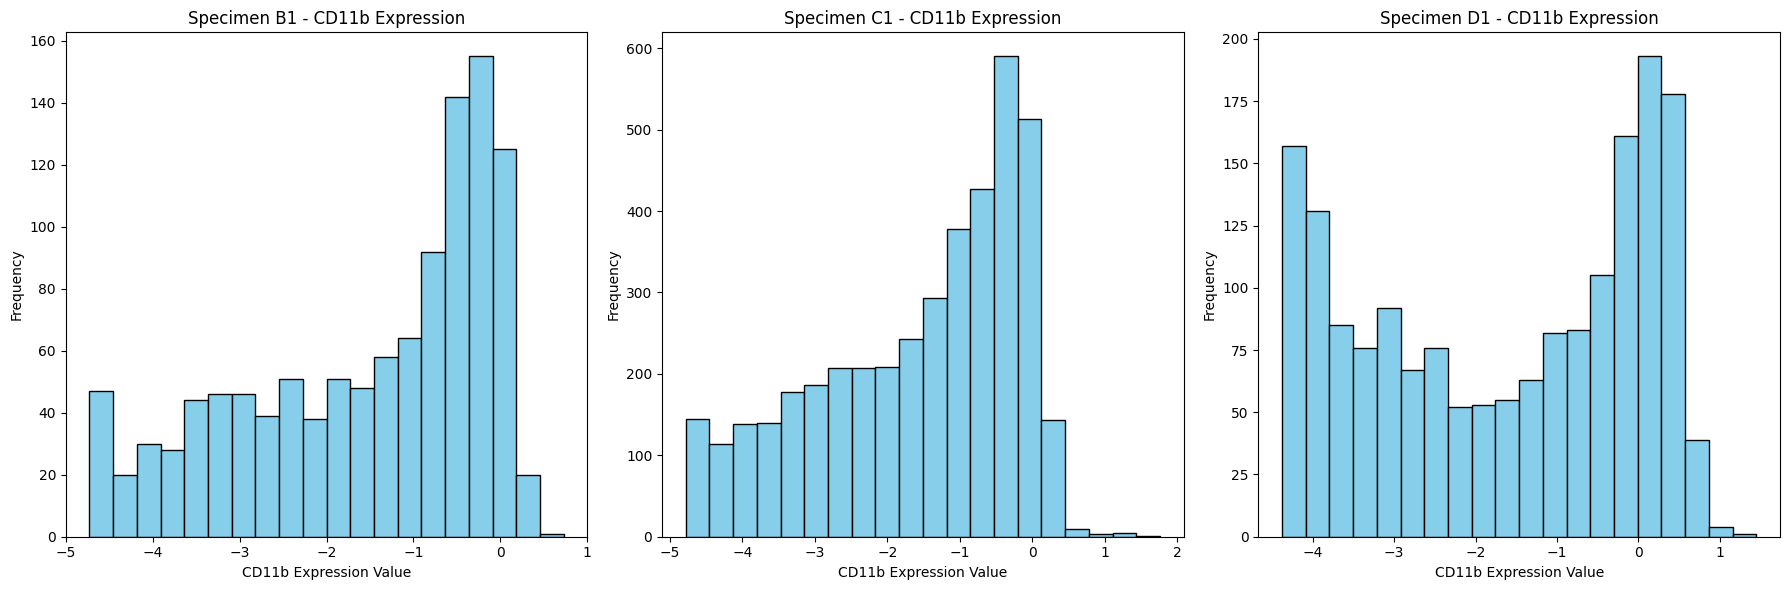

In [41]:
def q1_ii():
    df = get_csv()
    
    specimens = [s for s in df['specimen_id'].unique() if s != 'A1']

    plt.figure(figsize=(18, 6)) 

    for i, specimen in enumerate(specimens, 1):
        plt.subplot(1, 3, i)
        specimen_data = df.loc[df['specimen_id'] == specimen, 'CD11b']
        plt.hist(specimen_data, bins=20, color='skyblue', edgecolor='black')
        plt.title(f'Specimen {specimen} - CD11b Expression')
        plt.xlabel('CD11b Expression Value')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

q1_ii()


### iii
As the question suggests, by focusing on the Hematoxylin channel (H) to highlight cellular nuclei, we randomly selected 5 images and plotted them.

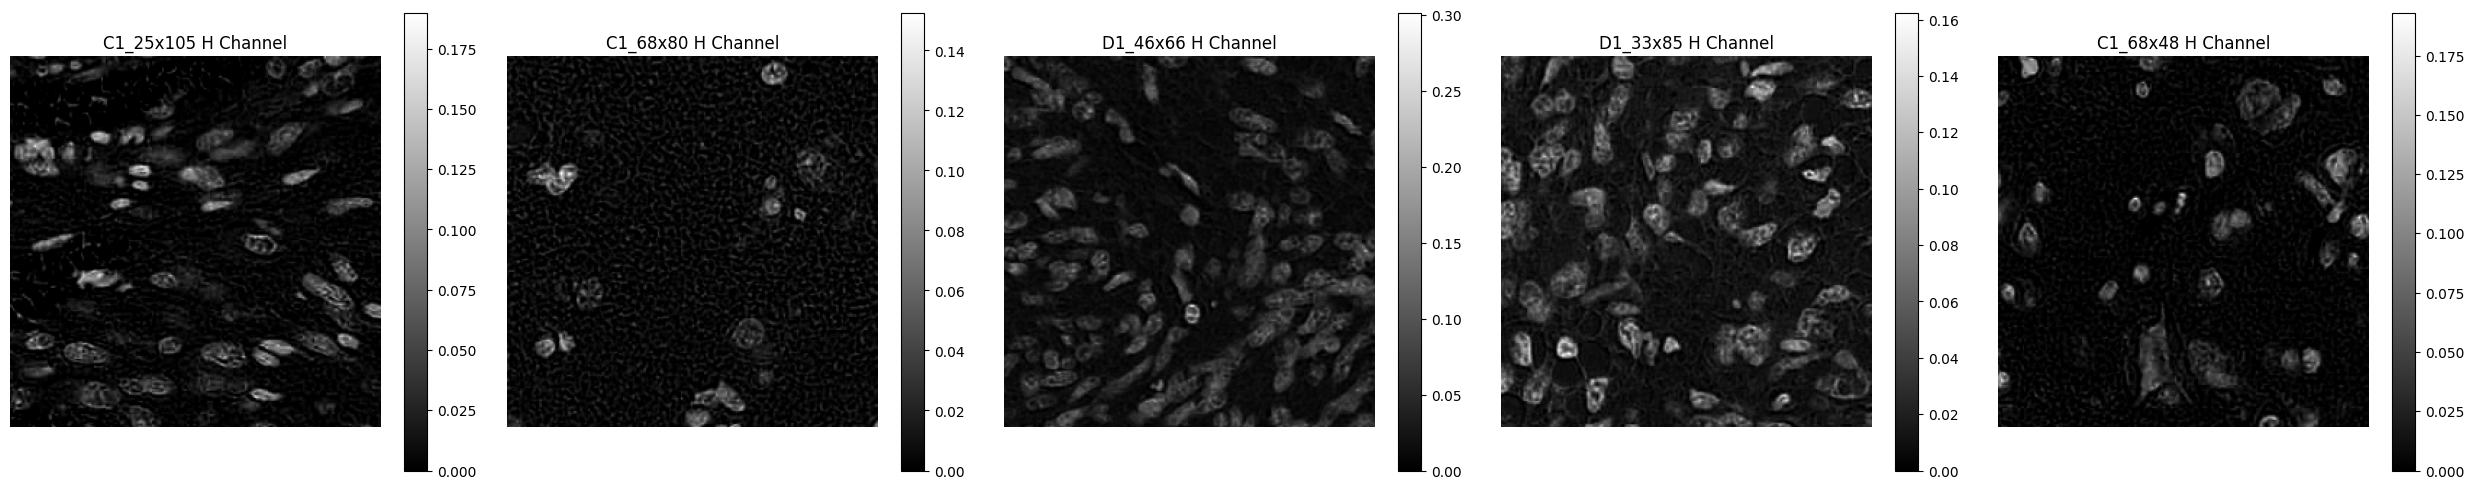

In [ ]:
def q1_iii():
    image_paths = get_path()

    filtered_paths = [path for path in image_paths if "A1" not in path]
    # randomly select 5 images 
    selected_paths = random.sample(filtered_paths, 5)
    n = len(selected_paths)
    
    plt.figure(figsize=(5 * n, 5))
    
    for idx, image_path in enumerate(selected_paths):
        img = imread(image_path)

        if img.shape[2] == 4:
            I = rgba2rgb(img)
        else:
            I = img
        
        image_name = image_path.split('/')[-1].split('.')[0]
        I_hed = rgb2hed(I)
        I_h = I_hed[:, :, 0]
        
        plt.subplot(1, n, idx + 1)
        plt.imshow(I_h, cmap='gray')
        plt.colorbar()
        plt.title(f"{image_name} H Channel")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

q1_iii()


### iv
We can see that the correlation between H-channel intensity and CD11b expression is -0.157, which is very close to 0, so it is not a good predictor for CD11b expression. And we can see from the graph that there is no clear trend between H-channel intensity and CD11b expression, which further suppoted our idea. 

In [81]:
def get_merge_df_q1_iv():
    def process_image(path):
       
        image_id = path.split('/')[-1].split('.')[0]
        img = imread(path)
        if img.shape[2] == 4:
            rgba_img = rgba2rgb(img)
            hed = rgb2hed(rgba_img)
        else:
            hed = rgb2hed(img)
        h_avg = np.mean(hed[:, :, 0])
        e_avg = np.mean(hed[:, :, 1])
        blue_avg = np.mean(img[:, :, 2])
        return {
            'image_id': image_id,
            'h_channel_avg': h_avg,
            'e_channel_avg': e_avg,
            'blue_channel_avg': blue_avg
        }
    df = get_csv()
    df = df[df['specimen_id'] != 'A1']

    image_paths = get_path()
    
    with ThreadPoolExecutor() as executor:
        data = list(executor.map(process_image, image_paths))

    channels_df = pd.DataFrame(data)
    final_df = pd.merge(df, channels_df, on='image_id', how='inner')

    return final_df

In [82]:
merged_df_q1 = get_merge_df_q1_iv()

Correlation between H-channel intensity and CD11b expression: -0.0734965362771965


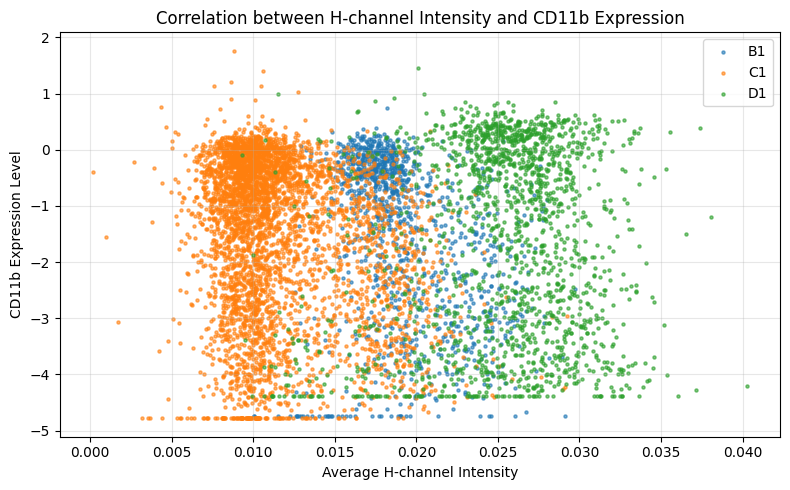

In [63]:
def q1_iv_i(merged_df):
    marker_size = 5 
    specimens = np.array(['B1', 'C1', 'D1'])

    plt.figure(figsize=(8, 5))

    for specimen in specimens:
        specimen_data = merged_df[merged_df['specimen_id'] == specimen]
        plt.scatter(specimen_data['h_channel_avg'], specimen_data['CD11b'], 
                    s=marker_size, alpha=0.6, label=specimen)

    plt.xlabel('Average H-channel Intensity')
    plt.ylabel('CD11b Expression Level')
    plt.title('Correlation between H-channel Intensity and CD11b Expression')
    plt.legend()
    plt.grid(True, alpha=0.3)

    correlation = merged_df['h_channel_avg'].corr(merged_df['CD11b'])
    print(f'Correlation between H-channel intensity and CD11b expression: {correlation}')

    plt.tight_layout()
    plt.show()

q1_iv_i(merged_df_q1)


### iv
We can see that correlation between E-channel intensity and CD11b expression is 0.27, which is very close to 0, suggesting E-channel intensity is not a good predictor for CD11b expression. This is further supported by the graph showing the correlation between E-channel intensity and CD11b expression, which indicates that there is no clear linear relationship between the variables.

Based on the plotted graph and the correlation between Blue-channel intensity and CD11b expression, it appears there is no linear relationship between the variables. The correlation is very low (-0.24), and the graph does not display any clear trend.

We found that all images in RGBA format have an average blue channel intensity close to 0 when the mean is calculated on an RGB image obtained by transforming the RGBA image using the **rgba2rgb** function. This could be due to the conversion process centering the images.

Correlation between E-channel intensity and CD11b expression: 0.27776240573408667
Correlation between Blue-channel intensity and CD11b expression: -0.2414694773824879


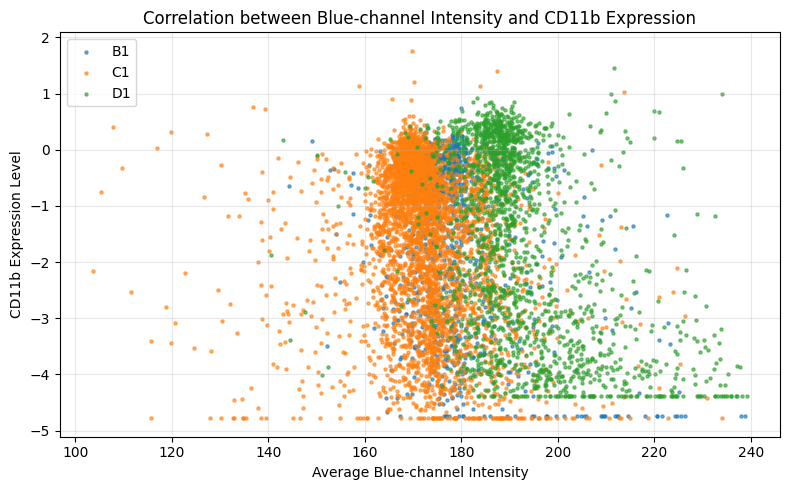

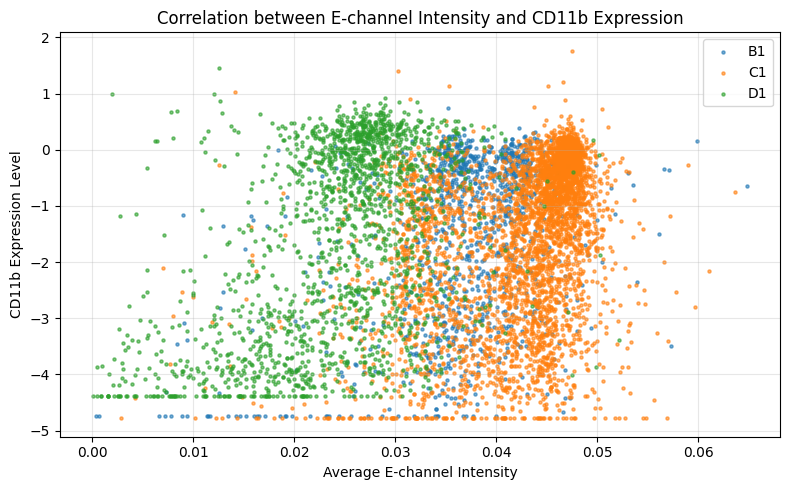

In [87]:
def q1_iv_ii(merged_df):
    marker_size = 5
    specimens = np.array(['B1', 'C1', 'D1'])

    correlation = merged_df['e_channel_avg'].corr(merged_df['CD11b'])
    print(f'Correlation between E-channel intensity and CD11b expression: {correlation}')

    blue_correlation = merged_df['blue_channel_avg'].corr(merged_df['CD11b'])
    print(f'Correlation between Blue-channel intensity and CD11b expression: {blue_correlation}')

    plt.figure(figsize=(8, 5))

    for specimen in specimens:
        specimen_data = merged_df[merged_df['specimen_id'] == specimen]
        plt.scatter(specimen_data['blue_channel_avg'], specimen_data['CD11b'], 
                    s=marker_size, alpha=0.6, label=specimen)

    plt.xlabel('Average Blue-channel Intensity')
    plt.ylabel('CD11b Expression Level')
    plt.title('Correlation between Blue-channel Intensity and CD11b Expression')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    for specimen in specimens:
        specimen_data = merged_df[merged_df['specimen_id'] == specimen]
        plt.scatter(specimen_data['e_channel_avg'], specimen_data['CD11b'], 
                    s=marker_size, alpha=0.6, label=specimen)

    plt.xlabel('Average E-channel Intensity')
    plt.ylabel('CD11b Expression Level')
    plt.title('Correlation between E-channel Intensity and CD11b Expression')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
q1_iv_ii(merged_df_q1)

### v
For specimen D1, there is a negative correlation between the average blue channel and the average H channel, suggesting that an increase in the average blue channel value leads to a decrease in the average H channel value. However, some samples actually show a positive correlation, indicating that there could be a heavy bias. Additionally, many samples fall within the 180 to 200 range for the average blue channel value, which suggests that the correlation may be due to chance.

For specimen C1, the majority of samples have average blue channel values in the 160 to 200 range. Some samples show a weak positive correlation—meaning that a large increase in the average blue channel value corresponds to a small increase in the average H channel value—but the overall trend is unclear, suggesting that this weak correlation could be due to chance.

For specimen B1, there is also a weak positive correlation; however, most of the data lie in the 160 to 180 range for the average blue channel value, again implying that the weak correlation could be due to chance.

Overall, specimen D1 exhibits the clearest correlation, while the other two specimens show no consistent correlation. The overall correlation between H and the blue channel is 0.37. Combined with the visual representation, this suggests that there is a weak relationship between the average blue channel and the H channel.

Correlation between Blue-channel intensity and H-channel: 0.36740569313640603


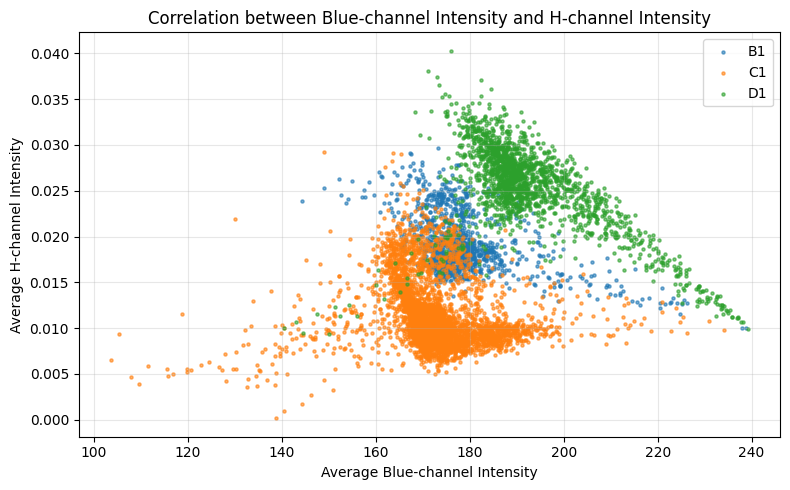

In [88]:
def q1_v_i(merged_df):
    marker_size = 5
    specimens = np.array(['B1', 'C1', 'D1'])

    blue_correlation = merged_df['h_channel_avg'].corr(merged_df['blue_channel_avg'])
    print(f'Correlation between Blue-channel intensity and H-channel: {blue_correlation}')


    plt.figure(figsize=(8, 5))

    for specimen in specimens:
        specimen_data = merged_df[merged_df['specimen_id'] == specimen]
        plt.scatter(specimen_data['blue_channel_avg'], specimen_data['h_channel_avg'], 
                    s=marker_size, alpha=0.6, label=specimen)

    plt.xlabel('Average Blue-channel Intensity')
    plt.ylabel('Average H-channel Intensity')
    plt.title('Correlation between Blue-channel Intensity and H-channel Intensity')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
q1_v_i(merged_df_q1)

### v
We can quantify the result using spearman or pearson correlation. We use spearman as pearson assume data are normally distributed, which we dont know. 

We can see from the heat map that there are some pair of proteins have quite high correlation between each other, suggesting these is association between protein expression levels of different proteins. Also, we see that DNA1 and DNA3 have a very high correlation, suggesting that they are closely connected.

We report the protein pair that have a high correlation (between 0.5 to 0.7) and very high correlation (above 0.7):

High correlation:
| Protein 1 | Protein 2 | Corr  | Protein 1 | Protein 2 | Corr  |
|-----------|-----------|-------|-----------|-----------|-------|
| CD11b     | PTEN      | 0.684 | VISTA     | CD74      | 0.554 |
| MET       | PDGFRa    | 0.684 | YKL40     | TMEM119 | 0.544 |
| IBA1      | HLADR     | 0.683 | IBA1      | CD68      | 0.544 |
| NESTIN    | SOX2      | 0.677 | YKL40     | cMYC      | 0.542 |
| CD74      | HLADR     | 0.669 | YKL40     | TCIRG1    | 0.539 |
| TMEM119 | MET       | 0.661 | PTEN      | TCIRG1    | 0.538 |
| IBA1      | P2RY12   | 0.657 | TMEM119 | P2RY12   | 0.533 |
| TCIRG1    | PDGFRa   | 0.657 | PTEN      | MET       | 0.531 |
| CDK4      | PDGFRa   | 0.650 | MET       | P2RY12    | 0.530 |
| MET       | cMYC      | 0.635 | TCIRG1    | P2RY12    | 0.528 |
| IBA1      | CD16      | 0.613 | TMEM119 | PTEN      | 0.526 |
| TCIRG1    | cMYC      | 0.599 | P2RY12    | HLADR     | 0.525 |
| CDK4      | EGFR      | 0.590 | CD163     | CD14      | 0.521 |
| CD74      | CD16      | 0.588 | YKL40     | MCT4      | 0.518 |
| SOX2      | PDGFRa   | 0.585 | HLADR     | CD16      | 0.518 |
| NESTIN    | EGFR      | 0.580 | CD68      | CD16      | 0.518 |
| TMEM119 | PDGFRa   | 0.575 | CDK4      | CD14      | 0.513 |
| CD74      | CD68      | 0.571 | CDK4      | PTEN      | 0.508 |
| TMEM119 | cMYC      | 0.569 | OLIG2     | SOX2      | 0.507 |
| CD74      | P2RY12   | 0.565 | PTEN      | PDGFRa    | 0.501 |

Very high correlation:
| Protein 1 | Protein 2 | Corr  | Protein 1 | Protein 2 | Corr  |
|-----------|-----------|-------|-----------|-----------|-------|
| DNA1      | DNA3      | 0.999 | IBA1      | CD74      | 0.743 |
| TCIRG1    | MET       | 0.828 | EGFR      | SOX2      | 0.729 |
| CDK4      | NESTIN    | 0.807 | TMEM119 | TCIRG1 | 0.711 |
| CDK4      | SOX2      | 0.799 |           |           |       |


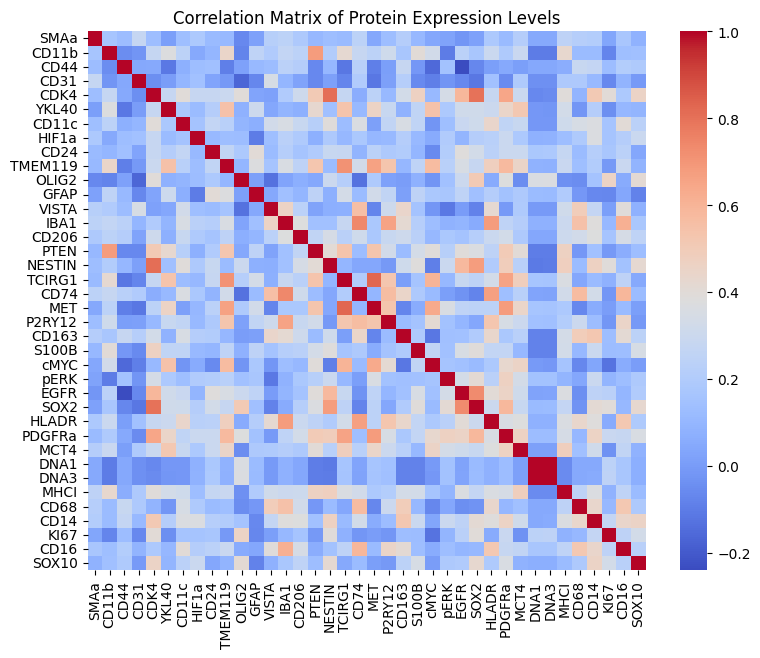

Protein pairs with high correlation:
('CD11b', 'PTEN', 0.684)
('MET', 'PDGFRa', 0.684)
('IBA1', 'HLADR', 0.683)
('NESTIN', 'SOX2', 0.677)
('CD74', 'HLADR', 0.669)
('TMEM119', 'MET', 0.661)
('IBA1', 'P2RY12', 0.657)
('TCIRG1', 'PDGFRa', 0.657)
('CDK4', 'PDGFRa', 0.65)
('MET', 'cMYC', 0.635)
('IBA1', 'CD16', 0.613)
('TCIRG1', 'cMYC', 0.599)
('CDK4', 'EGFR', 0.59)
('CD74', 'CD16', 0.588)
('SOX2', 'PDGFRa', 0.585)
('NESTIN', 'EGFR', 0.58)
('TMEM119', 'PDGFRa', 0.575)
('CD74', 'CD68', 0.571)
('TMEM119', 'cMYC', 0.569)
('CD74', 'P2RY12', 0.565)
('VISTA', 'CD74', 0.554)
('YKL40', 'TMEM119', 0.544)
('IBA1', 'CD68', 0.544)
('YKL40', 'cMYC', 0.542)
('YKL40', 'TCIRG1', 0.539)
('PTEN', 'TCIRG1', 0.538)
('TMEM119', 'P2RY12', 0.533)
('PTEN', 'MET', 0.531)
('MET', 'P2RY12', 0.53)
('TCIRG1', 'P2RY12', 0.528)
('TMEM119', 'PTEN', 0.526)
('P2RY12', 'HLADR', 0.525)
('CD163', 'CD14', 0.521)
('YKL40', 'MCT4', 0.518)
('HLADR', 'CD16', 0.518)
('CD68', 'CD16', 0.518)
('CDK4', 'CD14', 0.513)
('CDK4', 'PTEN', 0.

In [ ]:
def q1_v_ii():
    data_df = get_csv()
    data_df = data_df[data_df['specimen_id'] != 'A1']

    data_df = data_df[['SMAa', 'CD11b', 'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 'CD24', 'TMEM119',
                    'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 'NESTIN', 'TCIRG1',
                    'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 'pERK', 'EGFR',
                    'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 'MHCI', 'CD68',
                    'CD14', 'KI67', 'CD16', 'SOX10']]
    
    correlation_matrix = data_df.corr(method='spearman')

    plt.figure(figsize=(9, 7))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', 
                xticklabels=data_df.columns, yticklabels=data_df.columns)
    plt.title('Correlation Matrix of Protein Expression Levels')
    plt.show()

    high_corr_pairs = []
    very_high_corr_pairs = []
    for i, j in itertools.combinations(correlation_matrix.columns, 2):
        corr = float(correlation_matrix.loc[i, j])
        if 0.5 <= corr < 0.7:
            high_corr_pairs.append((i, j, round(corr, 3)))
        if corr >= 0.7:
            very_high_corr_pairs.append((i, j, round(corr, 3)))

    high_corr_pairs = sorted(high_corr_pairs, key=lambda x: x[2], reverse=True)
    very_high_corr_pairs = sorted(very_high_corr_pairs, key=lambda x: x[2], reverse=True)

    print("Protein pairs with high correlation:")
    for pair in high_corr_pairs:
        print(pair)

    print("Protein pairs with very high correlation:")
    for pair in very_high_corr_pairs:
        print(pair)
q1_v_ii()

# Question 2
## i 
### a
Here we calculate the Average and variance for each of the 'H',‘E’,‘D’ (from HED) and the original red, green, and blue channels:

In [ ]:
def process_image(path):
    image_id = path.split('/')[-1].split('.')[0]
    img = imread(path)
    if img.shape[2] == 4:
        # We use rgba2rgb to convert the image to rgb, but use original image to calculate the Average and Variance of RGB channels, as shown from question 1 that there could be zero mean in the RGB channels after conversion from rgba to rgb
        hed = rgb2hed(rgba2rgb(img))
        # rgb_img = rgba2rgb(img)
    else:
        hed = rgb2hed(img)
        # rgb_img = img
    h_avg = np.mean(hed[:, :, 0])
    e_avg = np.mean(hed[:, :, 1])
    d_avg = np.mean(hed[:, :, 2])
    h_var = np.var(hed[:, :, 0])
    e_var = np.var(hed[:, :, 1])
    d_var = np.var(hed[:, :, 2])
    red_avg = np.mean(img[:, :, 0])
    green_avg = np.mean(img[:, :, 1])
    blue_avg = np.mean(img[:, :, 2])
    red_var = np.var(img[:, :, 0])
    green_var = np.var(img[:, :, 1])
    blue_var = np.var(img[:, :, 2])
    
    return {
        'image_id': image_id,
        # we return the image, for pca
        'image_path': path,
        'h_channel_avg': h_avg,
        'e_channel_avg': e_avg,
        'd_channel_avg': d_avg,
        'h_channel_var': h_var,
        'e_channel_var': e_var,
        'd_channel_var': d_var,
        'red_channel_avg': red_avg,
        'green_channel_avg': green_avg,
        'blue_channel_avg': blue_avg,
        'red_channel_var': red_var,
        'green_channel_var': green_var,
        'blue_channel_var': blue_var
    }

def get_merge_df_q2():
    data_df = get_csv()
    # we do this to reduce memory usage
    data_df = data_df.drop(['SMAa', 'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 'CD24', 'TMEM119',
                             'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 'NESTIN', 'TCIRG1',
                             'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 'pERK', 'EGFR',
                             'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 'MHCI', 'CD68',
                             'CD14', 'KI67', 'CD16', 'SOX10', 'Unnamed: 0', 'VisSpot', 'Location_Center_Y',
                             'Location_Center_X', 'id'], axis=1)

    image_paths = get_path()

    data = []
    # use parallel processing to speed up the process
    with ThreadPoolExecutor() as executor:
        results = executor.map(process_image, image_paths)
        for result in results:
            data.append(result)
    
    added_df = pd.DataFrame(data)
    final_df = pd.merge(data_df, added_df, on='image_id', how='inner')
    return final_df


In [5]:
merged_df_q2 = get_merge_df_q2()

The code below shows the columns from the dataframe that contain the averages and variances for both the HED and RGB channels.

In [6]:
print(merged_df_q2.columns)

Index(['image_id', 'CD11b', 'specimen_id', 'image_path', 'h_channel_avg',
       'e_channel_avg', 'd_channel_avg', 'h_channel_var', 'e_channel_var',
       'd_channel_var', 'red_channel_avg', 'green_channel_avg',
       'blue_channel_avg', 'red_channel_var', 'green_channel_var',
       'blue_channel_var'],
      dtype='object')


### b
For we are using pca, we Standardize the data and get train test split. We use all specimen in A1 as test set and the rest as train set. Here we apply pca on the rbg image and HED image. 

As the test data is very different from the training data, we cannot use the number of principal components that explain 95% of the variance. Instead, we set the threshold to 60% to reduce overfitting.

We randomly select 2000 samples for experiment, We can see that 1 components capture 60% of the variance for RGB, and 308 components capture 60% of the variance for HED. Therefore, we now use these numbers of components for PCA.

In [6]:
# code to read in the images
def process_image(path):
    img = imread(path)
    if img.ndim == 3 and img.shape[2] == 4:
        img = rgba2rgb(img)
    return img
# this code need to be rechecked
def get_scaled_images_and_pca(df):
    n_samples=2000
    variance_threshold=0.6

    df = df[df['specimen_id'] != 'A1']
    sampled_paths = df['image_path'].sample(n=n_samples, random_state=0).tolist()
    
    rgb_features = []
    hed_features = []
    
    for path in sampled_paths:
        img = process_image(path)

        rgb_flat = img.flatten()
        rgb_features.append(rgb_flat)
        
        hed_img = rgb2hed(img)
        hed_flat = hed_img.flatten()
        hed_features.append(hed_flat)
    
    rgb_features = np.array(rgb_features)
    hed_features = np.array(hed_features)
    
    # scale the features
    rgb_scaler = StandardScaler()
    rgb_scaled = rgb_scaler.fit_transform(rgb_features)
    
    hed_scaler = StandardScaler()
    hed_scaled = hed_scaler.fit_transform(hed_features)
    
    # pca on rgb
    pca_rgb = PCA().fit(rgb_scaled)
    cumulative_variance_rgb = np.cumsum(pca_rgb.explained_variance_ratio_)
    n_components_rgb = np.searchsorted(cumulative_variance_rgb, variance_threshold) + 1
    
    # pca on hed
    pca_hed = PCA().fit(hed_scaled)
    cumulative_variance_hed = np.cumsum(pca_hed.explained_variance_ratio_)
    n_components_hed = np.searchsorted(cumulative_variance_hed, variance_threshold) + 1
    
    print(f"RGB: {n_components_rgb} components capture {variance_threshold*100:.0f}% of the variance.")
    print(f"HED: {n_components_hed} components capture {variance_threshold*100:.0f}% of the variance.")

get_scaled_images_and_pca(merged_df_q2)

RGB: 1 components capture 60% of the variance.
HED: 308 components capture 60% of the variance.


In [7]:
def process_image_with_resize(path, target_size=(224, 224)):
    img = imread(path)
    if img.ndim == 3 and img.shape[2] == 4:
        img = rgba2rgb(img)
    img_resized = resize(img, target_size, anti_aliasing=True)
    return img_resized

def get_rgb_features(paths):
    features = []
    for i in range(0, len(paths), 100):
        batch_paths = paths[i:i+100]
        for path in batch_paths:
            img = process_image_with_resize(path)
            features.append(img.flatten())
        gc.collect()
    return np.array(features)

def get_hed_features(paths):
    features = []
    for i in range(0, len(paths), 100):
        batch_paths = paths[i:i+100]
        for path in batch_paths:
            img = process_image_with_resize(path)
            hed_img = rgb2hed(img)
            features.append(hed_img.flatten())
        gc.collect()
    return np.array(features)

def transform_features_in_batches(paths, scaler, ipca, feature_mode='rgb'):
    transformed = []
    for i in range(0, len(paths), 100):
        batch_paths = paths[i:i+100]
        if feature_mode == 'rgb':
            batch_features = get_rgb_features(batch_paths)
        elif feature_mode == 'hed':
            batch_features = get_hed_features(batch_paths)
        else:
            raise ValueError("Unknown feature mode.")
        batch_scaled = scaler.transform(batch_features)
        batch_transformed = ipca.transform(batch_scaled)
        transformed.append(batch_transformed)
        del batch_features, batch_scaled, batch_transformed
        gc.collect()
    return np.vstack(transformed)

def fit_scaler_and_ipca(paths, get_features_fn,n_components):

    sample_paths = np.random.choice(paths, size=min(1000, len(paths)), replace=False)
    sample_features = get_features_fn(sample_paths)
    scaler = StandardScaler()
    scaler.fit(sample_features)

    ipca = IncrementalPCA(n_components=n_components)
    ipca.fit(scaler.transform(sample_features))
    del sample_features
    gc.collect()
    return scaler, ipca

def q2_i_memory_efficient(merged_df_q2):
    # Split DataFrame into training and test sets
    train_df = merged_df_q2[merged_df_q2['specimen_id'] != 'A1'].copy()
    test_df = merged_df_q2[merged_df_q2['specimen_id'] == 'A1'].copy()
    
    train_paths = train_df['image_path'].tolist()
    test_paths = test_df['image_path'].tolist()
    
    # process RGB features
    print("Fitting RGB scaler and IncrementalPCA on subset...")
    rgb_scaler, ipca_rgb = fit_scaler_and_ipca(train_paths, get_rgb_features,1)
    
    print("Transforming full RGB features...")
    train_rgb_ipca = transform_features_in_batches(train_paths, rgb_scaler, ipca_rgb,feature_mode='rgb')
    test_rgb_ipca = transform_features_in_batches(test_paths, rgb_scaler, ipca_rgb,feature_mode='rgb')
    # free menory
    del rgb_scaler, ipca_rgb
    gc.collect()
    
    # process HED features
    print("Fitting HED scaler and IncrementalPCA on subset...")
    hed_scaler, ipca_hed = fit_scaler_and_ipca(train_paths, get_hed_features,n_components=308)
    
    print("Transforming full HED features...")
    train_hed_ipca = transform_features_in_batches(train_paths, hed_scaler, ipca_hed,feature_mode='hed')
    test_hed_ipca = transform_features_in_batches(test_paths, hed_scaler, ipca_hed,feature_mode='hed')
    del hed_scaler, ipca_hed
    gc.collect()
    
    rgb_train_df = pd.DataFrame(train_rgb_ipca, index=train_df.index,
                                columns=[f'rgb_pc{i+1}' for i in range(train_rgb_ipca.shape[1])])
    rgb_test_df = pd.DataFrame(test_rgb_ipca, index=test_df.index,
                               columns=[f'rgb_pc{i+1}' for i in range(train_rgb_ipca.shape[1])])
    
    hed_train_df = pd.DataFrame(train_hed_ipca, index=train_df.index,
                                columns=[f'hed_pc{i+1}' for i in range(train_hed_ipca.shape[1])])
    hed_test_df = pd.DataFrame(test_hed_ipca, index=test_df.index,
                               columns=[f'hed_pc{i+1}' for i in range(train_hed_ipca.shape[1])])
    
    train_df = pd.concat([train_df, rgb_train_df, hed_train_df], axis=1)
    test_df = pd.concat([test_df, rgb_test_df, hed_test_df], axis=1)
    df_with_pca = pd.concat([train_df, test_df]).sort_index()
    
    return df_with_pca

merged_df_q2_with_pc = q2_i_memory_efficient(merged_df_q2)

Fitting RGB scaler and IncrementalPCA on subset...
Transforming full RGB features...
Fitting HED scaler and IncrementalPCA on subset...
Transforming full HED features...


In [98]:
print(merged_df_q2_with_pc.columns)

Index(['image_id', 'CD11b', 'specimen_id', 'image_path', 'h_channel_avg',
       'e_channel_avg', 'd_channel_avg', 'h_channel_var', 'e_channel_var',
       'd_channel_var',
       ...
       'hed_pc299', 'hed_pc300', 'hed_pc301', 'hed_pc302', 'hed_pc303',
       'hed_pc304', 'hed_pc305', 'hed_pc306', 'hed_pc307', 'hed_pc308'],
      dtype='object', length=325)


In [8]:
def get_train_test_q2(df):
    # we remove the A1 specimen as it is the test set
    train = df[df['specimen_id'] != 'A1']
    X_train = train.drop(['CD11b', 'specimen_id','image_id', 'image_path'], axis=1)
    y_train = train[['CD11b', 'image_id']]

    #  we only use the A1 specimen as the test
    test = df[df['specimen_id'] == 'A1']
    X_test = test.drop(['CD11b', 'specimen_id','image_id', 'image_path'], axis=1)
    y_test = test[['CD11b', 'image_id']]

    # print(X_train.columns)
    return X_train, X_test, y_train, y_test
X_train_q2, X_test_q2, y_train_q2, y_test_q2 = get_train_test_q2(merged_df_q2_with_pc)

We can see that after we transformed the pcs and get the average and variance of RGB and HED, there are lot of features has multicollinearity. We see that there are 16 features and 66 pairs of features has multicollinearity.

In [9]:
def report_high_corr_features(df, threshold=0.5):
    # Compute Spearman correlation matrix
    corr_matrix, _ = spearmanr(df, axis=0)
    features = df.columns.tolist()
    n_features = len(features)
    
    print(f"Total number of features: {n_features}")
    print(f"Correlated feature pairs (|correlation| > {threshold}):")
    correlated_feature_set = set()
    correlated_features = 0
    for i in range(n_features):
        for j in range(i + 1, n_features):
            if abs(corr_matrix[i, j]) > threshold:
                print(f"{features[i]} and {features[j]}: correlation = {corr_matrix[i, j]:.2f}")
                correlated_features += 1
                correlated_feature_set.add(features[i])
                correlated_feature_set.add(features[j])
    print(f"Total correlated feature pairs: {correlated_features}")
    print(f"Total number of unique correlated features: {len(correlated_feature_set)}")
    return correlated_feature_set

correlated_feature_set_q2_after_pca = report_high_corr_features(X_train_q2, threshold=0.5)

Total number of features: 321
Correlated feature pairs (|correlation| > 0.5):
h_channel_avg and e_channel_avg: correlation = -0.51
h_channel_avg and d_channel_avg: correlation = -0.62
h_channel_avg and h_channel_var: correlation = 0.93
h_channel_avg and e_channel_var: correlation = 0.70
h_channel_avg and red_channel_avg: correlation = -0.86
h_channel_avg and red_channel_var: correlation = 0.90
h_channel_avg and green_channel_var: correlation = 0.77
h_channel_avg and blue_channel_var: correlation = 0.73
h_channel_avg and hed_pc1: correlation = -0.66
h_channel_avg and hed_pc2: correlation = 0.80
h_channel_avg and hed_pc4: correlation = 0.57
e_channel_avg and d_channel_avg: correlation = 0.94
e_channel_avg and green_channel_avg: correlation = -0.97
e_channel_avg and blue_channel_avg: correlation = -0.95
e_channel_avg and green_channel_var: correlation = -0.66
e_channel_avg and blue_channel_var: correlation = -0.51
e_channel_avg and rgb_pc1: correlation = -0.95
e_channel_avg and hed_pc1: c

We want to apply PCA on these features again to reduce the multicollinearity. We see that only 2 pc is enough to explain 60 percent of explainable variance, so we transform the 17 features into one feature using pca. 

In [13]:
def find_num_components_explaining_variance(X):
    threshold=0.6

    scaler = StandardScaler()
    scaled = scaler.fit_transform(X)

    pca = PCA()
    pca.fit(scaled)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    num_components = np.searchsorted(cumulative_variance, threshold) + 1
    print(f"Number of PCs explaining at least 60% of the variance: {num_components}")

find_num_components_explaining_variance(X_train_q2.loc[:, X_train_q2.columns.isin(correlated_feature_set_q2_after_pca)])

Number of PCs explaining at least 60% of the variance: 2


We now apply pca on the linked features.

In [10]:
def apply_pca_on_features(train_df, test_df):

    train_image_ids = train_df['image_id']
    test_image_ids = test_df['image_id']
    train_specimen_ids = train_df['specimen_id']
    test_specimen_ids = test_df['specimen_id']
    
    train_features = train_df.drop(['image_id', 'specimen_id'], axis=1)
    test_features = test_df.drop(['image_id', 'specimen_id'], axis=1)
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_features)
    test_scaled = scaler.transform(test_features)
    
    pca = PCA(n_components=2)
    train_pca = pca.fit_transform(train_scaled)
    test_pca = pca.transform(test_scaled)

    train_pca_df = pd.DataFrame(train_pca, 
                                columns=[f'pc{i+1}' for i in range(2)], 
                                index=train_df.index)
    train_pca_df['image_id'] = train_image_ids.values
    train_pca_df['specimen_id'] = train_specimen_ids.values

    test_pca_df = pd.DataFrame(test_pca, 
                               columns=[f'pc{i+1}' for i in range(2)], 
                               index=test_df.index)
    test_pca_df['image_id'] = test_image_ids.values
    test_pca_df['specimen_id'] = test_specimen_ids.values

    return train_pca_df, test_pca_df

train_df = merged_df_q2_with_pc[merged_df_q2_with_pc['specimen_id'] == 'A1']
test_df = merged_df_q2_with_pc[merged_df_q2_with_pc['specimen_id'] != 'A1']

# make sure to filter the dataframes accordingly
cols_to_include = set(correlated_feature_set_q2_after_pca) | {'image_id','specimen_id'}
train_df_subset = train_df.loc[:, train_df.columns.isin(cols_to_include)]
test_df_subset = test_df.loc[:, test_df.columns.isin(cols_to_include)]

train_pca_df, test_pca_df = apply_pca_on_features(train_df_subset, test_df_subset)

train_pca_df = train_pca_df.drop(['specimen_id'], axis=1)
test_pca_df = test_pca_df.drop(['specimen_id'], axis=1)

merged_df_q2_with_pc_without_corr_features = merged_df_q2_with_pc.drop(correlated_feature_set_q2_after_pca, axis=1)

print("Train PCA DataFrame columns:", train_pca_df.columns)
print("Train PCA DataFrame shape:", train_pca_df.shape)
print("Test PCA DataFrame columns:", test_pca_df.columns)
print("Test PCA DataFrame shape:", test_pca_df.shape)
print("Train DataFrame with other features columns:", merged_df_q2_with_pc_without_corr_features.columns)
print("Train DataFrame with other features shape:", merged_df_q2_with_pc_without_corr_features.shape)

Train PCA DataFrame columns: Index(['pc1', 'pc2', 'image_id'], dtype='object')
Train PCA DataFrame shape: (2894, 3)
Test PCA DataFrame columns: Index(['pc1', 'pc2', 'image_id'], dtype='object')
Test PCA DataFrame shape: (7027, 3)
Train DataFrame with other features columns: Index(['image_id', 'CD11b', 'specimen_id', 'image_path', 'hed_pc3', 'hed_pc5',
       'hed_pc6', 'hed_pc7', 'hed_pc8', 'hed_pc9',
       ...
       'hed_pc299', 'hed_pc300', 'hed_pc301', 'hed_pc302', 'hed_pc303',
       'hed_pc304', 'hed_pc305', 'hed_pc306', 'hed_pc307', 'hed_pc308'],
      dtype='object', length=309)
Train DataFrame with other features shape: (9921, 309)


We check if the combined df is indeed 9921 colunms.

In [11]:
combined_test_train_df_q2 = pd.concat([train_pca_df, test_pca_df], axis=0, ignore_index=True)
print("Combined DataFrame shape:", combined_test_train_df_q2.shape)
print("Combined DataFrame columns:", combined_test_train_df_q2.columns)
print("Original DataFrame shape:", merged_df_q2_with_pc_without_corr_features.shape)
print("Original DataFrame columns:", merged_df_q2_with_pc_without_corr_features.columns)

Combined DataFrame shape: (9921, 3)
Combined DataFrame columns: Index(['pc1', 'pc2', 'image_id'], dtype='object')
Original DataFrame shape: (9921, 309)
Original DataFrame columns: Index(['image_id', 'CD11b', 'specimen_id', 'image_path', 'hed_pc3', 'hed_pc5',
       'hed_pc6', 'hed_pc7', 'hed_pc8', 'hed_pc9',
       ...
       'hed_pc299', 'hed_pc300', 'hed_pc301', 'hed_pc302', 'hed_pc303',
       'hed_pc304', 'hed_pc305', 'hed_pc306', 'hed_pc307', 'hed_pc308'],
      dtype='object', length=309)


We merge to prevent oreder get lost of order. We see there are 311 features, which is correct as there are 308 hed pc, 1 rgb pc, 12 avg and var of hed and rgb. In total that is 321, and remove 16 features, add back two features, that is 307 features. The other four are ['CD11b', 'specimen_id','image_id','image_path'], which we will remove later.

In [12]:
merged_df_q2_with_pc_without_corr_features = pd.merge(combined_test_train_df_q2, merged_df_q2_with_pc_without_corr_features, on='image_id', how='inner')
# the shape is correct
print(merged_df_q2_with_pc_without_corr_features.shape)
print(merged_df_q2_with_pc_without_corr_features.columns)

(9921, 311)
Index(['pc1', 'pc2', 'image_id', 'CD11b', 'specimen_id', 'image_path',
       'hed_pc3', 'hed_pc5', 'hed_pc6', 'hed_pc7',
       ...
       'hed_pc299', 'hed_pc300', 'hed_pc301', 'hed_pc302', 'hed_pc303',
       'hed_pc304', 'hed_pc305', 'hed_pc306', 'hed_pc307', 'hed_pc308'],
      dtype='object', length=311)


In [14]:
def get_train_test_q2(df):
    # we remove the A1 specimen as it is the test set
    train = df[df['specimen_id'] != 'A1']
    X_train = train.drop(['CD11b', 'specimen_id','image_id','image_path'], axis=1)
    # y_train = train[['CD11b']]
    y_train = train[['CD11b']].values.ravel()

    #  we only use the A1 specimen as the test
    test = df[df['specimen_id'] == 'A1']
    X_test = test.drop(['CD11b', 'specimen_id','image_id','image_path'], axis=1)
    # y_test = test[['CD11b']]
    y_test = test[['CD11b']].values.ravel()

    return X_train, X_test, y_train, y_test

X_train_q2_final, X_test_q2_final, y_train_q2_final, y_test_q2_final = get_train_test_q2(merged_df_q2_with_pc_without_corr_features)

We check if there are any non-standerdized features, as all features are processed by pca, they should not need to Standardize the data later. 

In [24]:
for name in X_train_q2_final.columns:
    if 'pc' not in name:
        print(name)

### ii
RMSE measures the average magnitude of the errors, providing a direct sense of the model's performance. Since we dont care about interpretbility, so we can just use MSE.

In the cell below we do hyperparameters tunning and try OLS, L1 and L2 regression, support vector regression and random forest model.

In [ ]:
def get_models_q2(X_train_q2, y_train_q2):
    models = {
        'OLS': {
            'estimator': LinearRegression(),
            'param_distributions': {} 
        },
        'Ridge': {
            'estimator': Ridge(),
            'param_distributions': {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
        },
        'Lasso': {
            'estimator': Lasso(max_iter=10000),
            'param_distributions': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
        },
        'Decision Tree': {
            'estimator': RandomForestRegressor(),
            'param_distributions': {'max_depth': [None, 1, 3, 5, 10, 20],
                                    'n_estimators': [10,50, 100, 
                                                     500, 1000],
                                    'min_samples_split': [2, 5, 10],
                                    'min_samples_leaf': [1, 2, 4],
                                    'max_features': ['sqrt', 'log2'],
                                    'bootstrap': [True, False]
                                    }}}

    best_models = {}
    for name, config in models.items():
        print(f"Tuning {name} model...")
    
        random_search = RandomizedSearchCV(
            estimator=config['estimator'],
            param_distributions=config['param_distributions'],
            n_iter=20,             
            cv=5,                  
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            random_state=0,
            verbose=2
        )
        
        random_search.fit(X_train_q2, y_train_q2)
        best_models[name] = random_search.best_estimator_
    return best_models

best_models_q2 = get_models_q2(X_train_q2_final, y_train_q2_final)

Tuning OLS model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.1s[CV] END .................................................... total time=   0.1s

[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


/Users/msakaki/miniconda3/envs/native/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuning Ridge model...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..................

/Users/msakaki/miniconda3/envs/native/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuning Lasso model...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.1s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..................

/Users/msakaki/miniconda3/envs/native/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuning Decision Tree model...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END bootstrap=False, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_sp

In [91]:
import joblib

# To save the model
joblib.dump(best_models_q2, 'best_model_Q2_with307features.pkl')

['best_model_Q2_with307features.pkl']

## Results for Q2

The small p values for all models suggest there should be no linear correlation. We see there is almost no change in OLS to L1 or L2. 
The best performance is the diagonal line. 

The small p-values for both Pearson and Spearman for all the models suggest that we should not reject the null hypothesis, which states that the correlation is zero.

The small R-square value for all the models suggest the predicted value does not match the real data very well. 

The RMSE for all the models is also quite large for the data, suggesting the model is not performing well.

The graph shows that the predicted values from all the models do not match the actual values; instead, they tend toward a horizontal line, suggesting that the model predicts nearly the same value for all samples.

Here is a table of Performance metrics on test data:
| Model           | RMSE  | R-squared | Pearson Corr (p-value)    | Spearman Corr (p-value)    |
|-----------------|-------|-----------|---------------------------|----------------------------|
| **OLS**         | 1.482 | -0.065    | 0.112 (1.622e-09)         | 0.092 (6.629e-07)          |
| **Ridge**       | 1.482 | -0.064    | 0.112 (1.591e-09)         | 0.092 (6.448e-07)          |
| **Lasso**       | 1.468 | -0.045    | 0.103 (2.948e-08)         | 0.061 (1.082e-03)          |
| **Decision Tree** | 1.391 | 0.062   | 0.331 (6.325e-75)         | 0.338 (3.754e-78)          |

Evaluating OLS model...
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
OLS - RMSE: 1.482
OLS - R-squared: -0.065
OLS - Pearson Correlation Coefficient: 0.112 (p-value: 1.622e-09)
OLS - Spearman Correlation Coefficient: 0.092 (p-value: 6.629e-07)
Evaluating Ridge model...
{'alpha': 100.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
Ridge - RMSE: 1.482
Ridge - R-squared: -0.064
Ridge - Pearson Correlation Coefficient: 0.112 (p-value: 1.591e-09)
Ridge - Spearman Correlation Coefficient: 0.092 (p-value: 6.448e-07)
Evaluating Lasso model...
{'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': 10000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
Lasso - RMSE: 1.468
Lasso - R-squared: -0.045
Lasso - Pearson Correlation Coefficient: 0.103 (p-value: 2.948e-08)
Lasso - Spearman Correlation Coeffi

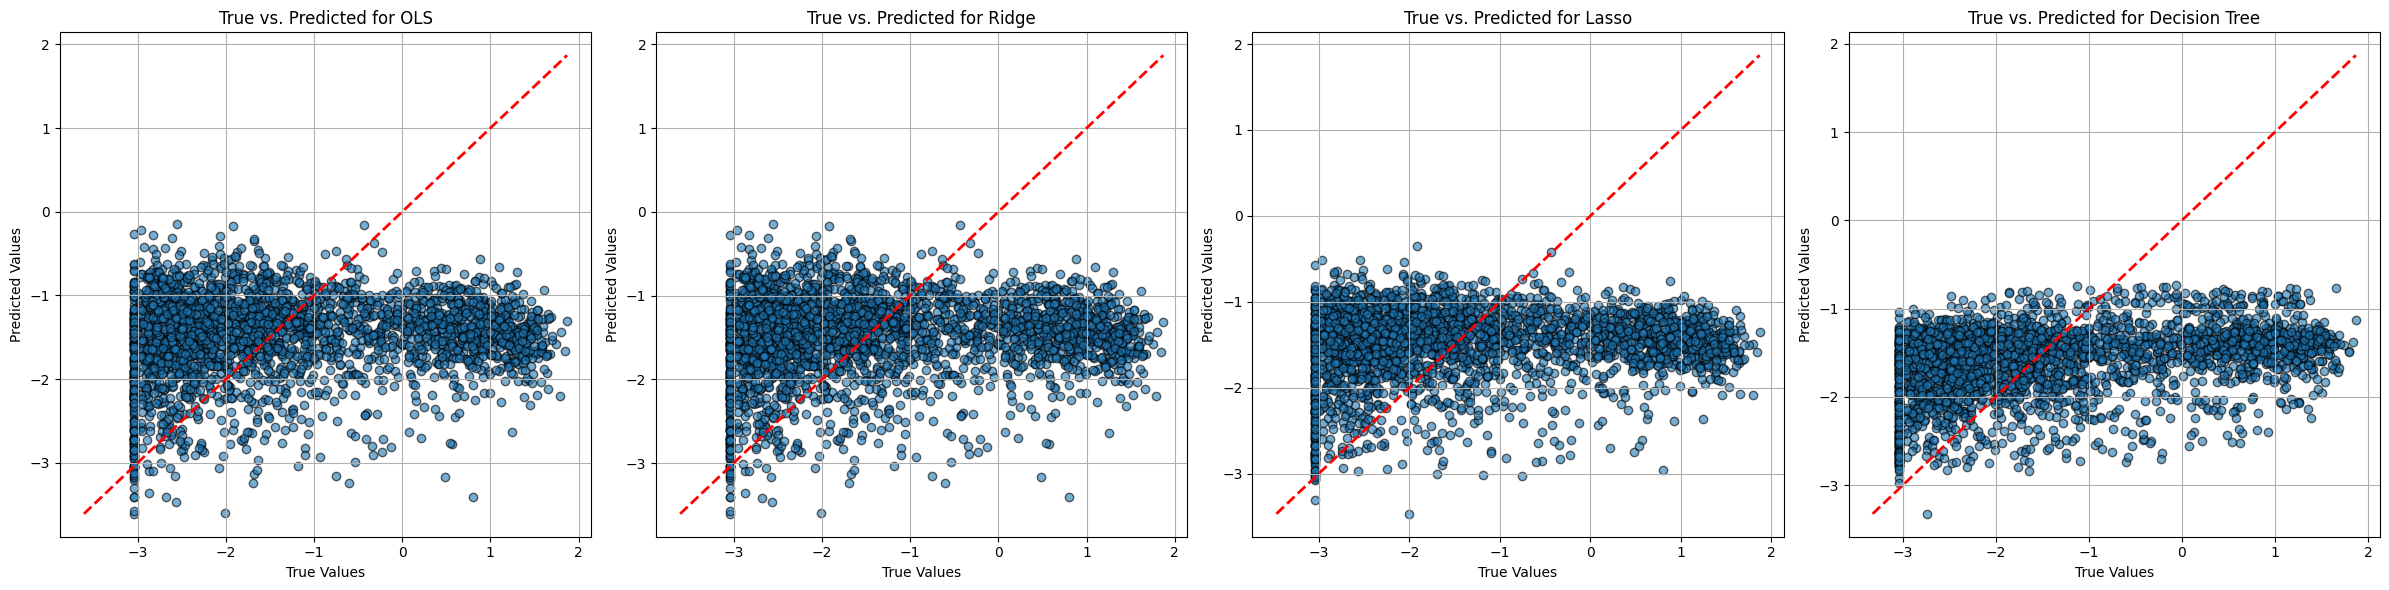

In [71]:
def get_Deliverables_q2( X_test_q2, y_test_q2, best_models_q2):
    best_models = best_models_q2
    n_models = len(best_models)
    
    fig, axs = plt.subplots(1, n_models, figsize=(6 * n_models, 6))
    
    for i, (name, model) in enumerate(best_models.items()):
        print(f"Evaluating {name} model...")
        print(model.get_params())
        # model.fit(X_train_q2, y_train_q2)
        y_pred = model.predict(X_test_q2)
        
        rmse = np.sqrt(mean_squared_error(y_test_q2, y_pred))
        print(f'{name} - RMSE: {rmse:.3f}')
        
        r2 = r2_score(y_test_q2, y_pred)
        print(f'{name} - R-squared: {r2:.3f}')
        
        pearson_corr, p_pearson = pearsonr(y_test_q2, y_pred)
        print(f'{name} - Pearson Correlation Coefficient: {pearson_corr:.3f} (p-value: {p_pearson:.3e})')
        
        spearman_corr, p_spearman = spearmanr(y_test_q2, y_pred)
        print(f'{name} - Spearman Correlation Coefficient: {spearman_corr:.3f} (p-value: {p_spearman:.3e})')
        
        ax = axs[i]
        ax.scatter(y_test_q2, y_pred, alpha=0.6, edgecolors='k')
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f"True vs. Predicted for {name}")
      
        min_val = min(np.min(y_test_q2), np.min(y_pred))
        max_val = max(np.max(y_test_q2), np.max(y_pred))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

get_Deliverables_q2( X_test_q2_final, y_test_q2_final, best_models_q2)

# Question 3
## i

The code below downloads the ResNet-152 model from PyTorch Hub if it has not already been downloaded. We have commented it out to prevent it from executing every time.

In [ ]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)

In [72]:
# here we load the data
def get_merge_df_q3_i():
    data_df = get_csv()
    # we do this to reduce memory usage
    data_df = data_df.drop(['SMAa', 'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 'CD24', 'TMEM119',
                         'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 'NESTIN', 'TCIRG1',
                         'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 'pERK', 'EGFR',
                         'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 'MHCI', 'CD68',
                         'CD14', 'KI67', 'CD16', 'SOX10','Unnamed: 0','VisSpot','Location_Center_Y','Location_Center_X',
                         'id'], axis=1)

    image_paths = get_path()

    data = []
    for path in image_paths:
        image_id = path.split('/')[-1].split('.')[0]

        data.append({
            'image_id': image_id,
            'image_path': path
        })

    added_df = pd.DataFrame(data)

    final_df = pd.merge(data_df, added_df, on='image_id', how='inner')

    return final_df

In [73]:
data_df_q3_i = get_merge_df_q3_i()

In [ ]:
print(data_df_q3_i.columns)

Index(['image_id', 'CD11b', 'specimen_id', 'image_path'], dtype='object')


### Train test split

In [74]:
def train_test_split_q3(df):
    # we remove the A1 specimen as it is the test set
    train = df[df['specimen_id'] != 'A1']
    X_train = train[['image_path']].values.ravel()
    y_train = train[['CD11b']].values.ravel()

    #  we only use the A1 specimen as the test
    test = df[df['specimen_id'] == 'A1']
    X_test = test[['image_path']].values.ravel()
    y_test = test[['CD11b']].values.ravel()

    return X_train, X_test, y_train, y_test


train_paths_q3_i, test_paths_q3_i, train_labels_q3_i, test_labels_q3_i = train_test_split_q3(data_df_q3_i)

In [ ]:
# there are intoal 7027 images, we use 20% for validation, which is about 1405 images
print(train_paths_q3_i.shape)

(7027,)


### RESNET

We use ResNet152 for this task because it is a strong model and easy to use, as we can access it directly from the PyTorch hub. We chose the 152-layer version because it is the largest and best-performing model available on the PyTorch hub.

We add an additional fully connected layer at the end of the model to generate the regression output.
For data preparation, we use the original image but transform it into the HED color space, then apply min-max normalization, then we normalize it again using information form WordNet, as it is the original dataset used for training of ResNet. We want our samples be similar to training samples originally used for trianing the base model. 

During training, we unfreeze only the final layer—layer4 of ResNet—and freeze the other layers. Layer4 is the last block of the original ResNet152 model, and this approach saves time and computational resources compared to fine-tuning the entire model. Additionally, layer4 contains high-level abstract features with a high number of channels, which enhances the model's performance. This is also an effective transfer learning method. We further train the final fully connected layer to convert the model's output into a regression value.

From the graph, we observe that the validation error levels off between 50 and 100 epochs, so we run 300 epochs to prevent underfitting.

In [ ]:
device = 'mps'  # you may need to change this to 'cuda' or 'cpu' depending on your setup

Epoch 1/300
Training Loss: 2.0359
Validation Loss: 1.7002
Model updated (new best validation loss)
Epoch 2/300
Training Loss: 0.9530
Validation Loss: 1.4324
Model updated (new best validation loss)
Epoch 3/300
Training Loss: 0.6016
Validation Loss: 1.2867
Model updated (new best validation loss)
Epoch 4/300
Training Loss: 0.3579
Validation Loss: 1.2946
Epoch 5/300
Training Loss: 0.2244
Validation Loss: 1.2836
Model updated (new best validation loss)
Epoch 6/300
Training Loss: 0.1563
Validation Loss: 1.2842
Epoch 7/300
Training Loss: 0.1187
Validation Loss: 1.2887
Epoch 8/300
Training Loss: 0.0954
Validation Loss: 1.3175
Epoch 9/300
Training Loss: 0.0920
Validation Loss: 1.2845
Epoch 10/300
Training Loss: 0.0700
Validation Loss: 1.2769
Model updated (new best validation loss)
Epoch 11/300
Training Loss: 0.0781
Validation Loss: 1.2876
Epoch 12/300
Training Loss: 0.0633
Validation Loss: 1.2833
Epoch 13/300
Training Loss: 0.0531
Validation Loss: 1.2723
Model updated (new best validation lo

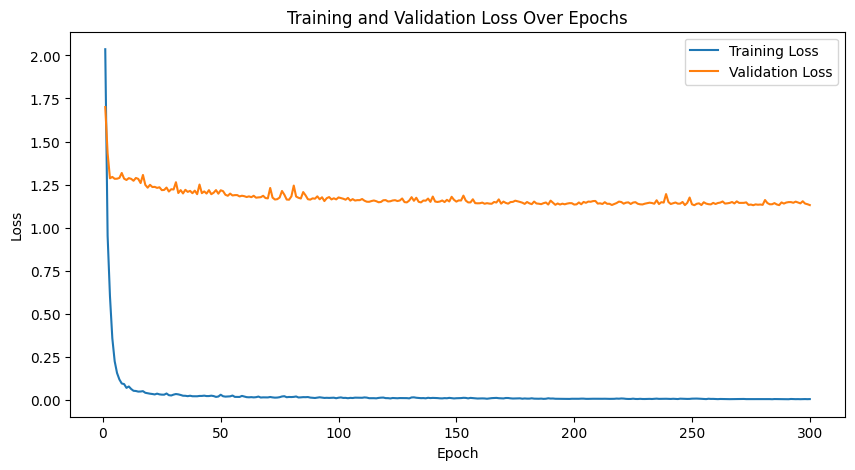

In [ ]:
class ProteinExpressionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels 
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = imread(path)
     
        if img.shape[-1] == 4:
            from skimage.color import rgba2rgb
            img = rgba2rgb(img)

        img = rgb2hed(img)
        img = (img - img.min()) / (img.max() - img.min() + 1e-8) # minmax normalization
        img = img.astype(np.float32)
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label
    
data_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((224, 224)), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # data from imagenet, where resnet was trained
                         std=[0.229, 0.224, 0.225])    
])

# dataset and dataloader
resnet_dataset = ProteinExpressionDataset(train_paths_q3_i, train_labels_q3_i, transform=data_transforms)
generator = torch.Generator().manual_seed(0)
train, valid = random_split(resnet_dataset,[5622,1405], generator=generator)

resnet_dataloader = DataLoader(train, batch_size=256, shuffle=True)

val_dataloader = DataLoader(valid, batch_size=256, shuffle=False)

# model creation
resnet_model = resnet152(weights=ResNet152_Weights.DEFAULT)
# freeze all layers
for param in resnet_model.parameters():
    param.requires_grad = False
# add one more layer for regression
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 1)
resnet_model = resnet_model.to(device)

for name, param in resnet_model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True

criterion = nn.MSELoss()
optimizer = optim.Adam(
    [param for name, param in resnet_model.named_parameters() if 'layer4' in name or 'fc' in name],
    lr=1e-4
)

# training loop
train_losses = []
val_losses = []

best_val_loss = float('inf')

num_epochs = 300

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # training
    resnet_model.train()
    running_loss = 0.0
    for imgs, targets in resnet_dataloader:
        imgs, targets = imgs.to(device), targets.to(device).unsqueeze(1)
        
        optimizer.zero_grad()  
        
        outputs = resnet_model(imgs.float())  
        loss = criterion(outputs, targets)   
        
        loss.backward() 
        optimizer.step() 
        
        running_loss += loss.item() * imgs.size(0)
    
    train_loss = running_loss / len(resnet_dataset)
    train_losses.append(train_loss)
    print(f"Training Loss: {train_loss:.4f}")

    # validation
    resnet_model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for imgs, targets in val_dataloader:
            imgs, targets = imgs.to(device), targets.to(device).unsqueeze(1)
            outputs = resnet_model(imgs.float())
            loss = criterion(outputs, targets)
            val_running_loss += loss.item() * imgs.size(0)
    
    val_loss = val_running_loss / len(valid)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")
    
    # model update on validation
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # save the best model weights
        best_model_wts = copy.deepcopy(resnet_model.state_dict())
        torch.save(resnet_model.state_dict(), 'best_model_q3_i.pth')
        print("Model updated (new best validation loss)")

resnet_model.eval()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

### Result for Q3_i

Here we present the performance of the neural network. We observe that the performance is poor, with a large RMSE and a negative R², suggesting that the model cannot accurately predict protein expression. A negative R² means that the model is performing worse than the baseline model, which always predicts the mean value of the target variable. Additionally, both the Pearson and Spearman correlation coefficients indicate that the predicted and actual protein expression levels do not match.

We can also see from the graph that while the model is capable of predicting a wider range of protein expression values than the classical models, its overall performance is not as good as the random forest. Moreover, the behavior of the neural network is similar to that of the classical models in that it tends to predict roughly the same value for all samples.

| Metric                              | Value                             |
|-------------------------------------|-----------------------------------|
| Test Loss                           | 3.043                             |
| RMSE                                | 1.744                             |
| R-squared                           | -0.475                            |
| Pearson Correlation Coefficient     | 0.024 (p-value: 1.91e-01)         |
| Spearman Correlation Coefficient    | 0.046 (p-value: 1.29e-02)         |

Test Loss: 3.0425
RMSE: 1.7443
R-squared: -0.4751
Pearson Correlation Coefficient: 0.0243 (p-value: 1.9085e-01)
Spearman Correlation Coefficient: 0.0462 (p-value: 1.2859e-02)


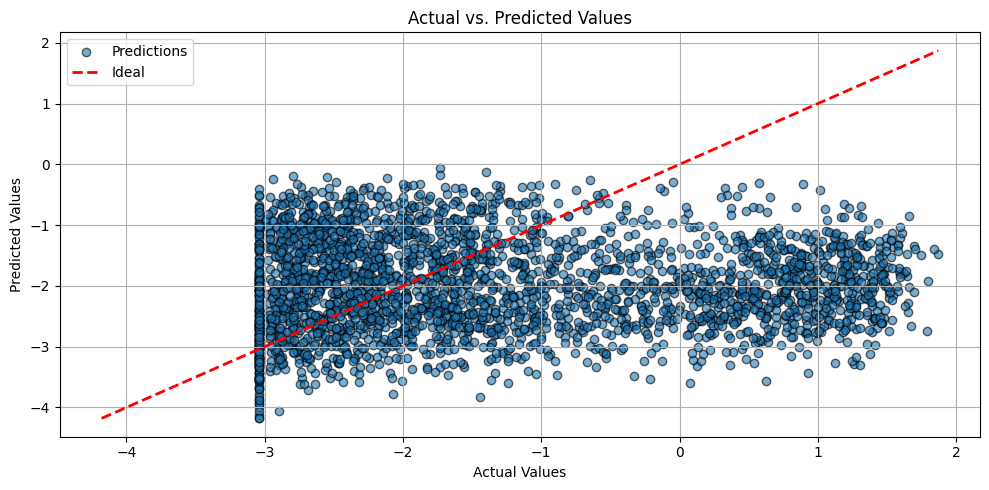

In [92]:
resnet_test_dataset = ProteinExpressionDataset(test_paths_q3_i, test_labels_q3_i, transform=data_transforms)
resnet_test_dataloader = DataLoader(resnet_test_dataset, batch_size=256, shuffle=False)

test_loss = 0.0
all_preds = []
all_targets = []

with torch.no_grad():
    for imgs, targets in resnet_test_dataloader:
        imgs = imgs.to(device)
        targets = targets.to(device).unsqueeze(1)  
        outputs = resnet_model(imgs.float())
        loss = criterion(outputs, targets)
        test_loss += loss.item() * imgs.size(0)

        all_preds.extend(outputs.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

avg_test_loss = test_loss / len(resnet_test_dataset)
print(f"Test Loss: {avg_test_loss:.4f}")

all_preds = np.array(all_preds).flatten()
all_targets = np.array(all_targets).flatten()

# RMSE
mse = np.mean((all_preds - all_targets)**2)
rmse = np.sqrt(mse)

# R2 score
r2 = r2_score(all_targets, all_preds)

# Pearson Correlation Coefficient
pearson_corr, pearson_p = pearsonr(all_targets, all_preds)

# Spearman Correlation Coefficient
spearman_corr, spearman_p = spearmanr(all_targets, all_preds)

print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f} (p-value: {pearson_p:.4e})")
print(f"Spearman Correlation Coefficient: {spearman_corr:.4f} (p-value: {spearman_p:.4e})")

plt.figure(figsize=(10, 5))
plt.scatter(all_targets, all_preds, alpha=0.6, edgecolors='k', label='Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

min_val = min(np.min(all_targets), np.min(all_preds))
max_val = max(np.max(all_targets), np.max(all_preds))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Consolidated table

Here we show all the models used for predicting CD11b expression levels, using Specimen A1 as the test set and the others as the training set. We observe that the decision tree classifier has the best performance across all metrics.

The neural network does not perform as well and has the lowest R² score, suggesting that the model is capturing information that differs significantly between the training set and the test set. As the decision tree is the largest and most complex model, it should theoretically perform the best. This discrepancy could be due to the fact that Specimen A1 is quite different from the rest of the specimens, even though they visually appear similar.

| Model           | RMSE  | R-squared | Pearson Corr (p-value)    | Spearman Corr (p-value)    |
|-----------------|-------|-----------|---------------------------|----------------------------|
| **OLS**         | 1.482 | -0.065    | 0.112 (1.622e-09)         | 0.092 (6.629e-07)          |
| **Ridge**       | 1.482 | -0.064    | 0.112 (1.591e-09)         | 0.092 (6.448e-07)          |
| **Lasso**       | 1.468 | -0.045    | 0.103 (2.948e-08)         | 0.061 (1.082e-03)          |
| **Decision Tree** | 1.391 | 0.062   | 0.331 (6.325e-75)         | 0.338 (3.754e-78)          |
| **Neural Network**| 1.744 | -0.475  | 0.024 (1.91e-01)          | 0.046 (1.29e-02)           |

## ii
### RESNET

For this question, we use data from all the specimens as training data and apply GroupKFold validation. We train the model on each subset of the training data and validate it, then use the best-performing model to train on all the training examples.

We use the average Spearman correlation coefficient to determine the best model across folds, and we only train the final fully connected layer with all the training samples. These decisions are based on experimental results that showed the best performance. The other model structures remain the same as in Q3i, using a ResNet152 model with a fully connected layer at the end and the same data preparation.

For this task, we only use 100 epochs, as we observed in the previous question that there is no benefit from training for more than 100 epochs. Additionally, the model used for this question takes longer to train, so using fewer epochs saves time.

In [ ]:
device = 'cuda'  # you may need to change this to 'cuda' or 'cpu' depending on your setup

In [5]:
def get_merge_df_q3_ii():
    data_df = get_csv()
    # we do this to reduce memory usage
    data_df = data_df.drop(['Unnamed: 0','VisSpot','Location_Center_Y','Location_Center_X','id'], axis=1)

    image_paths = get_path()

    data = []
    for path in image_paths:
        image_id = path.split('/')[-1].split('.')[0]

        data.append({
            'image_id': image_id,
            'image_path': path
        })

    added_df = pd.DataFrame(data)

    final_df = pd.merge(data_df, added_df, on='image_id', how='inner')

    return final_df

In [6]:
data_df_q3_ii = get_merge_df_q3_ii()

Here we do train test split.

In [7]:
protein_list = ['SMAa', 'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 'CD24', 'TMEM119',
                'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 'NESTIN', 'TCIRG1',
                'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 'pERK', 'EGFR',
                'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 'MHCI', 'CD68',
                'CD14', 'KI67', 'CD16', 'SOX10', 'CD11b']

image_paths = data_df_q3_ii['image_path'].tolist()
labels = data_df_q3_ii[protein_list].values 

train_paths_q3_ii, test_paths_q3_ii, train_labels_q3_ii, test_labels_q3_ii = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)
group_train = data_df_q3_ii.loc[data_df_q3_ii['image_path'].isin(train_paths_q3_ii), 'specimen_id']
group_test = data_df_q3_ii.loc[data_df_q3_ii['image_path'].isin(test_paths_q3_ii), 'specimen_id']

Here are some helper methods

In [8]:
# This methoo help us to save model during training, to prevent kudu server from crashing
def save_model(resnet_model_fold, num_epochs, optimizer, epoch_loss):
    checkpoint = {
        'epoch': num_epochs,  
        'model_state_dict': resnet_model_fold.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss  
    }

    torch.save(checkpoint, 'model_checkpoint_q3_ii.pth')
    print("Checkpoint saved to 'model_checkpoint.pth'")

In [18]:
# same as Q3_i
class ProteinExpressionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = imread(self.image_paths[idx])
        if img.shape[-1] == 4:
            img = rgba2rgb(img)
        img = rgb2hed(img).astype(np.float32)
  
        img = (img - img.min()) / (img.max() - img.min() + 1e-8) 
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
num_proteins = len(protein_list) 


### Model with layer 4, layer 3 and the fully connected layer unfrozen

Here we train the model.

The code below is used to train ResNet-152 with one additional fully connected layer at the end for regression. This code shows how we trained our best-performing model and how it performed during training. The model is trained with layer 3, layer 4 of the original ResNet-152, and the added fully connected layer unfrozen.

We lost the results showing how the model behaved during training when only the final fully connected layer was unfrozen, and we also lost some results for the model trained with both the final fully connected layer and layer 4 unfrozen. This occurred because an old Jupyter Notebook on the Kudu server was overwritten when accessing it remotely, so the old file with only partial results replaced the file containing all the results. However, we did save the model to an external file, so we can still see how it performed on the test set.

Here, we see that during group fold validation, the model's performance is as expected: the validation and training losses decrease together in the early epochs, and then the validation loss flattens while the training loss continues to drop. However, for the final model trained on all the data, the model does not perform well on the validation set. Although the training error continues to decrease, the validation loss rises as the model develops. This could be due to the fact that the differences between specimens are quite significant, and a model performing well on some specimens does not necessarily perform well on data from all specimens.

In [ ]:
# some helper functions
def get_model():
    model = resnet152(weights=ResNet152_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    for name, param in model.named_parameters():
        if 'layer3' in name or 'layer4' in name or 'fc' in name:
            param.requires_grad = True
    model.fc = nn.Linear(model.fc.in_features, num_proteins)
    return model.to(device)

# helper function with inner validation
def train_model_with_inner_validation(model, train_loader, val_loader, criterion, optimizer, epochs=100, save_interval=10):
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # training 
        model.train()
        running_train_loss = 0.0
        for imgs, targets in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(imgs.float())
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * imgs.size(0)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # inner validation 
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device)
                outputs = model(imgs.float())
                loss = criterion(outputs, targets)
                running_val_loss += loss.item() * imgs.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

        # save the best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = copy.deepcopy(model.state_dict())

        if (epoch + 1) % save_interval == 0:
            save_model(model, epoch, optimizer, epoch_train_loss)
            
    return model, train_losses, val_losses 

# function for evaluation
def evaluate_model(model, loader):
    model.eval()
    preds, truths = [], []
    with torch.no_grad():
        for imgs, targets in loader:
            imgs, targets = imgs.to(device), targets.to(device)
            outputs = model(imgs.float())
            preds.append(outputs.cpu().numpy())
            truths.append(targets.cpu().numpy())
    return np.concatenate(preds), np.concatenate(truths)


=== Fold 1 ===
Epoch 1/100, Train Loss: 1.7286, Val Loss: 0.8871
Epoch 2/100, Train Loss: 0.7216, Val Loss: 0.7169
Epoch 3/100, Train Loss: 0.5699, Val Loss: 0.6998
Epoch 4/100, Train Loss: 0.4739, Val Loss: 0.6706
Epoch 5/100, Train Loss: 0.4105, Val Loss: 0.6664
Epoch 6/100, Train Loss: 0.3544, Val Loss: 0.6592
Epoch 7/100, Train Loss: 0.3092, Val Loss: 0.6585
Epoch 8/100, Train Loss: 0.2656, Val Loss: 0.6636
Epoch 9/100, Train Loss: 0.2255, Val Loss: 0.6658
Epoch 10/100, Train Loss: 0.1896, Val Loss: 0.6661
Checkpoint saved to 'model_checkpoint.pth'
Epoch 11/100, Train Loss: 0.1657, Val Loss: 0.6707
Epoch 12/100, Train Loss: 0.1403, Val Loss: 0.6685
Epoch 13/100, Train Loss: 0.1215, Val Loss: 0.6719
Epoch 14/100, Train Loss: 0.1064, Val Loss: 0.6658
Epoch 15/100, Train Loss: 0.0918, Val Loss: 0.6741
Epoch 16/100, Train Loss: 0.0853, Val Loss: 0.6696
Epoch 17/100, Train Loss: 0.0712, Val Loss: 0.6771
Epoch 18/100, Train Loss: 0.0648, Val Loss: 0.6747
Epoch 19/100, Train Loss: 0.0581

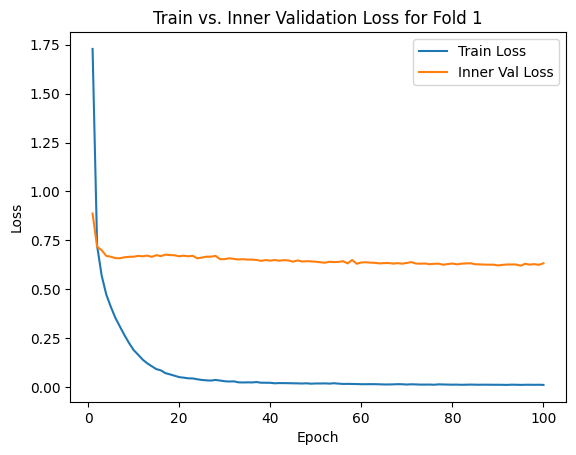

Fold 1 Spearman per protein: [0.06821024132872301, 0.45075480484992586, -0.0033580530145721136, 0.7724892120273508, 0.45725896168346547, 0.3475200428618263, 0.2406988592315075, 0.4220035831058198, 0.47020709567286045, 0.2598296891232371, 0.3543999846587926, 0.3010634245679062, 0.33365485104705594, 0.2498286028086173, 0.5852321241889467, 0.7359168227205173, 0.6278200647032635, 0.3463906276063701, 0.6565611092363137, 0.44174283582981333, 0.4149482139997976, 0.6146916067444093, 0.5917602961218134, 0.6555086571870452, 0.6329300208174647, 0.679812469283844, 0.53958165846568, 0.6207369322460591, 0.431176047973662, 0.3961360198856224, 0.3918726954303283, 0.634637994439611, 0.2918829470075724, 0.5359791559026319, 0.23253650824055977, 0.2541520285379313, 0.41308828550849586, 0.6397172837769227]
Fold 1 Average Spearman: 0.4497

=== Fold 2 ===
Epoch 1/100, Train Loss: 1.6261, Val Loss: 0.8272
Epoch 2/100, Train Loss: 0.6826, Val Loss: 0.7034
Epoch 3/100, Train Loss: 0.5403, Val Loss: 0.6741
Epoch

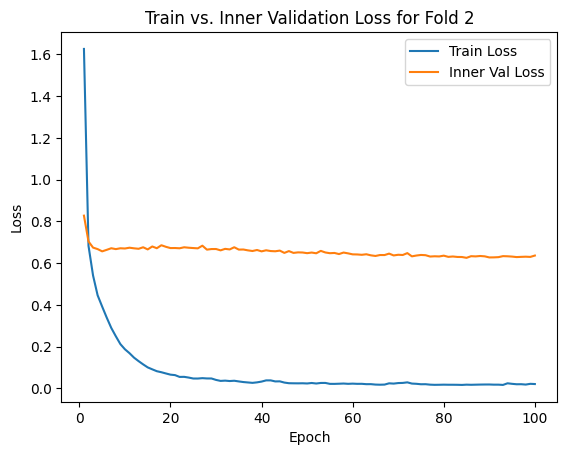

Fold 2 Spearman per protein: [0.14148805269365466, 0.4551414150065887, 0.061688145759168166, 0.7713519767692093, 0.4852796358283864, 0.35966556205959677, 0.22295256331044017, 0.4180358597172903, 0.5154046845888669, 0.25462265084930197, 0.4274105090340885, 0.27633332497306656, 0.31320125532829773, 0.29898092409846116, 0.6298058844945392, 0.7252755388534807, 0.6307869934798603, 0.3858706899389796, 0.686851643092643, 0.42963634645593574, 0.4199274081319062, 0.6578256069532931, 0.6209431872551006, 0.6341329333475447, 0.6657897501842434, 0.6853694319930809, 0.5521542132638465, 0.6084100190664422, 0.429103531830991, 0.39358270200097706, 0.3962318078565826, 0.6514396934657665, 0.3200546649216564, 0.5655235671983945, 0.24135145112707337, 0.29997125842775546, 0.4536974979611782, 0.6539905266549035]
Fold 2 Average Spearman: 0.4668

=== Fold 3 ===
Epoch 1/100, Train Loss: 1.4289, Val Loss: 0.8647
Epoch 2/100, Train Loss: 0.6536, Val Loss: 0.7300
Epoch 3/100, Train Loss: 0.5127, Val Loss: 0.7107
E

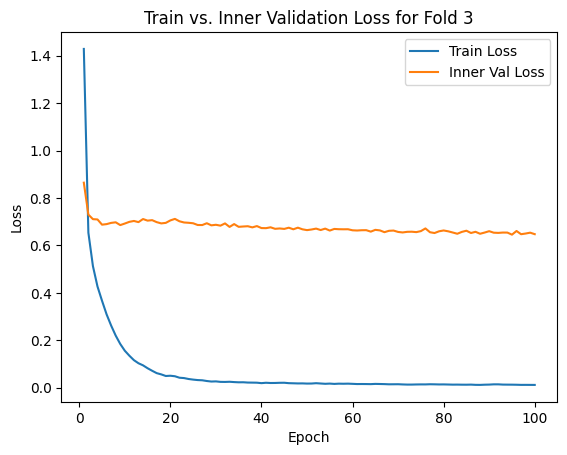

Fold 3 Spearman per protein: [0.08552186242834155, 0.49841104502433903, 0.02849327636068722, 0.8123205969782269, 0.527760268458376, 0.41108578025099124, 0.2484506325014514, 0.4657137962614476, 0.48667421038996883, 0.2612295191318391, 0.431459997425309, 0.3136116814520479, 0.3186548376317419, 0.2794394182532753, 0.6354188422904284, 0.737663752046837, 0.6518991887434705, 0.37004117148845705, 0.6833408596575726, 0.45167594391257093, 0.3821642961226784, 0.6646266558972446, 0.6541117717308627, 0.699555916122093, 0.6728549720539414, 0.7134382947149003, 0.5418109874855744, 0.6332707008435002, 0.476709202377629, 0.44145792584613086, 0.43902262674267206, 0.664417563741115, 0.3597622308934922, 0.5563701532621023, 0.21955917594249866, 0.2873974332148444, 0.4541782694280093, 0.6607112324491192]
Fold 3 Average Spearman: 0.4795

=== Fold 4 ===
Epoch 1/100, Train Loss: 1.4135, Val Loss: 0.7246
Epoch 2/100, Train Loss: 0.6613, Val Loss: 0.6400
Epoch 3/100, Train Loss: 0.5244, Val Loss: 0.6271
Epoch 4/

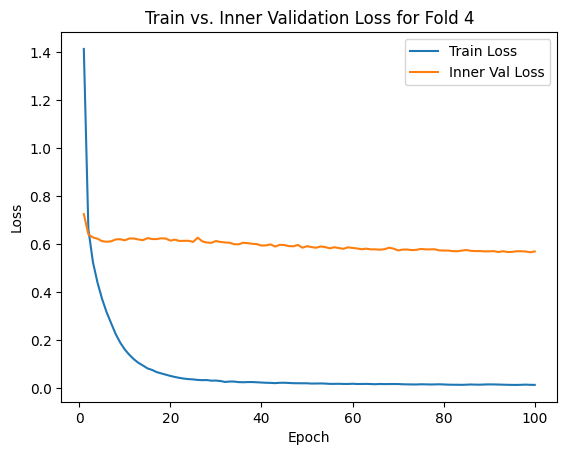

Fold 4 Spearman per protein: [0.10598663018942035, 0.536148440731812, 0.07248093862673645, 0.7988972792475737, 0.5047693122818744, 0.3805712979382041, 0.2348214551801722, 0.5038014769039988, 0.41766578000082777, 0.3039206337886326, 0.49945922257495207, 0.3009548659837975, 0.3088793335575939, 0.3395009010915249, 0.6156144702339418, 0.7622009188211134, 0.6344042286088243, 0.3881491884165938, 0.6809035995873471, 0.46171612694821546, 0.4413278932053878, 0.6864477906478827, 0.6487868131046031, 0.7083676955769863, 0.6838281202840716, 0.7167364996960566, 0.5363781254569523, 0.582567015796045, 0.42659602427237975, 0.4485919929593636, 0.462871375311592, 0.6716465017629115, 0.2725257278798235, 0.5464178569268782, 0.2789772329611829, 0.30776352272213825, 0.4947339146375234, 0.6869838955558623]
Fold 4 Average Spearman: 0.4856

Best fold is Fold 4 with Average Spearman: 0.4856
Epoch 1/100, Train Loss: 0.1742, Val Loss: 0.1630
Epoch 2/100, Train Loss: 0.1720, Val Loss: 0.1633
Epoch 3/100, Train Loss

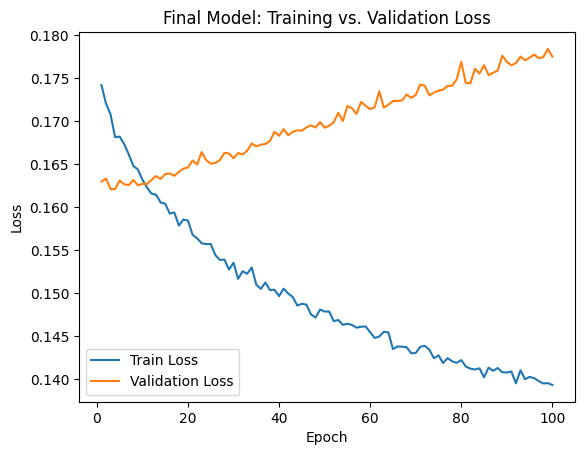

In [ ]:
groups = group_train.tolist()
gkf = GroupKFold(n_splits=len(np.unique(groups)))
all_fold_avg_spearman = []

best_model_state = None
best_avg_spearman = -np.inf
best_fold_index = -1

# groupkfold validation loop
for fold, (train_idx, outer_val_idx) in enumerate(
        gkf.split(train_paths_q3_ii, train_labels_q3_ii, groups), 1):
    print(f"\n=== Fold {fold} ===")
    
    #  model, criterion, and optimizer
    model = get_model()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
    [param for name, param in model.named_parameters() if 'layer3' in name or 'layer4' in name or 'fc' in name],
    lr=1e-4)
    
    # outer training and validation datasets
    train_dataset = ProteinExpressionDataset(
        [train_paths_q3_ii[i] for i in train_idx],
        train_labels_q3_ii[train_idx],
        transform=data_transforms
    )
    outer_val_dataset = ProteinExpressionDataset(
        [train_paths_q3_ii[i] for i in outer_val_idx],
        train_labels_q3_ii[outer_val_idx],
        transform=data_transforms
    )
    
    # Split the outer training set into inner training (80%) and validation (20%)
    inner_train_size = int(len(train_dataset) * 0.8)
    inner_val_size = len(train_dataset) - inner_train_size
    inner_train_dataset, inner_val_dataset = random_split(train_dataset, [inner_train_size, inner_val_size])
    
    inner_train_loader = DataLoader(inner_train_dataset, batch_size=128, shuffle=True)
    inner_val_loader = DataLoader(inner_val_dataset, batch_size=128, shuffle=False)
    outer_val_loader = DataLoader(outer_val_dataset, batch_size=128, shuffle=False)

    model, train_losses, val_losses = train_model_with_inner_validation(
        model, inner_train_loader, inner_val_loader, criterion, optimizer)
    
    plt.figure()
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Inner Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train vs. Inner Validation Loss for Fold {fold}')
    plt.legend()
    plt.show()
    
    # evaluate on the outer validation set (GroupKFold split)
    val_preds, val_truths = evaluate_model(model, outer_val_loader)
    
    # Spearman correlation 
    fold_spearman = [spearmanr(val_truths[:, i], val_preds[:, i])[0] for i in range(num_proteins)]
    avg_spearman = np.mean(fold_spearman)
    print(f"Fold {fold} Spearman per protein: {fold_spearman}")
    print(f"Fold {fold} Average Spearman: {avg_spearman:.4f}")
    all_fold_avg_spearman.append(avg_spearman)
    
    # save best model
    if avg_spearman > best_avg_spearman:
        best_avg_spearman = avg_spearman
        best_model_state = copy.deepcopy(model.state_dict())
        best_fold_index = fold

print(f"\nBest fold is Fold {best_fold_index} with Average Spearman: {best_avg_spearman:.4f}")

# Use the best model from validation as the final model and further train on all data

final_model = get_model()
final_model.load_state_dict(best_model_state)

# train validation split
final_dataset = ProteinExpressionDataset(train_paths_q3_ii, train_labels_q3_ii, transform=data_transforms)
train_size = int(0.8 * len(final_dataset))
val_size = len(final_dataset) - train_size
final_train_dataset, final_val_dataset = random_split(final_dataset, [train_size, val_size])

final_train_loader = DataLoader(final_train_dataset, batch_size=128, shuffle=True)
final_val_loader = DataLoader(final_val_dataset, batch_size=128, shuffle=False)

criterion_final = nn.MSELoss()
optimizer_final = optim.Adam(final_model.fc.parameters(), lr=1e-4)
num_epochs_final = 100

final_model, final_train_losses, final_val_losses = train_model_with_inner_validation(
    final_model, final_train_loader, final_val_loader, criterion_final, optimizer_final,
    epochs=num_epochs_final, save_interval=10
)

save_model(final_model, num_epochs_final, optimizer_final, final_train_losses[-1])
print("Final model training complete using the best performing model from k-fold CV.")

plt.figure()
plt.plot(range(1, len(final_train_losses) + 1), final_train_losses, label='Train Loss')
plt.plot(range(1, len(final_val_losses) + 1), final_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final Model: Training vs. Validation Loss')
plt.legend()
plt.show()

### Model with layer 4 and the fully connected layer unfrozen

The model is about the same as before, with some changes in how the model is defined and in the optimizer. We lost some output during training because an old ipynb on the Kudu server overwrote the new one, so only some of the outputs were preserved (training and validation error from the first three folds). However, the other two graphs are similar to those from the model with layer 4 and layer 3 unfrozen, as shown above.

In [ ]:
def get_model():
    model = resnet152(weights=ResNet152_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    for name, param in model.named_parameters():
        if 'layer4' in name or 'fc' in name:
            param.requires_grad = True
    model.fc = nn.Linear(model.fc.in_features, num_proteins)
    return model.to(device)


=== Fold 1 ===
Epoch 1/100, Train Loss: 2.0726, Val Loss: 1.0623
Epoch 2/100, Train Loss: 0.8119, Val Loss: 0.8141
Epoch 3/100, Train Loss: 0.6513, Val Loss: 0.7442
Epoch 4/100, Train Loss: 0.5770, Val Loss: 0.7308
Epoch 5/100, Train Loss: 0.5195, Val Loss: 0.7136
Epoch 6/100, Train Loss: 0.4704, Val Loss: 0.6984
Epoch 7/100, Train Loss: 0.4392, Val Loss: 0.7033
Epoch 8/100, Train Loss: 0.4043, Val Loss: 0.6865
Epoch 9/100, Train Loss: 0.3746, Val Loss: 0.6834
Epoch 10/100, Train Loss: 0.3470, Val Loss: 0.6812
Checkpoint saved to 'model_checkpoint.pth'
Epoch 11/100, Train Loss: 0.3171, Val Loss: 0.6870
Epoch 12/100, Train Loss: 0.2932, Val Loss: 0.6831
Epoch 13/100, Train Loss: 0.2652, Val Loss: 0.6819
Epoch 14/100, Train Loss: 0.2477, Val Loss: 0.6788
Epoch 15/100, Train Loss: 0.2302, Val Loss: 0.6766
Epoch 16/100, Train Loss: 0.2101, Val Loss: 0.6844
Epoch 17/100, Train Loss: 0.1900, Val Loss: 0.6904
Epoch 18/100, Train Loss: 0.1743, Val Loss: 0.6825
Epoch 19/100, Train Loss: 0.1619

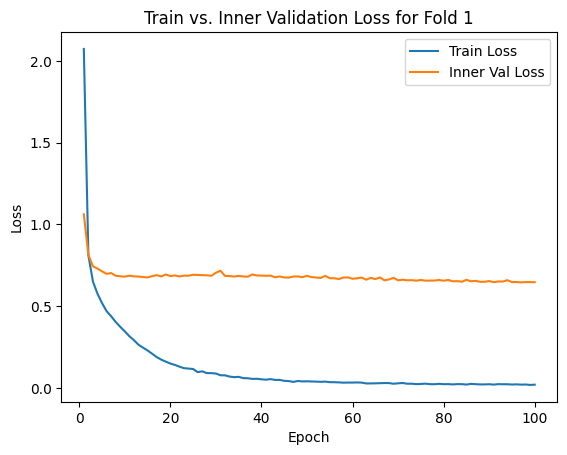

Fold 1 Spearman per protein: [0.10891944202932449, 0.41730309365220486, 0.043213854914421146, 0.7622974468060293, 0.47219570772228153, 0.3101485452190394, 0.21241109474585826, 0.3989637952324606, 0.4420724636894418, 0.22012202014131219, 0.3616501429353748, 0.24262776419284904, 0.32398070815765306, 0.24024593727916416, 0.5958195661446654, 0.7290140813984227, 0.613869966199101, 0.3361310845749332, 0.6331570441390012, 0.42061778816257644, 0.3766997196492338, 0.6265386347321199, 0.5941265089400575, 0.6450804959617162, 0.6243725561522333, 0.6472558364534828, 0.5252833237559498, 0.5885116870027514, 0.405897743815056, 0.3902249663169919, 0.3788151474986027, 0.6311172578604916, 0.28871456843716126, 0.4974491561499246, 0.18993139681856624, 0.2575268665964051, 0.3830066872425571, 0.6334832283459135]
Fold 1 Average Spearman: 0.4360

=== Fold 2 ===
Epoch 1/100, Train Loss: 1.9088, Val Loss: 0.9331
Epoch 2/100, Train Loss: 0.7544, Val Loss: 0.7414
Epoch 3/100, Train Loss: 0.6261, Val Loss: 0.7059
E

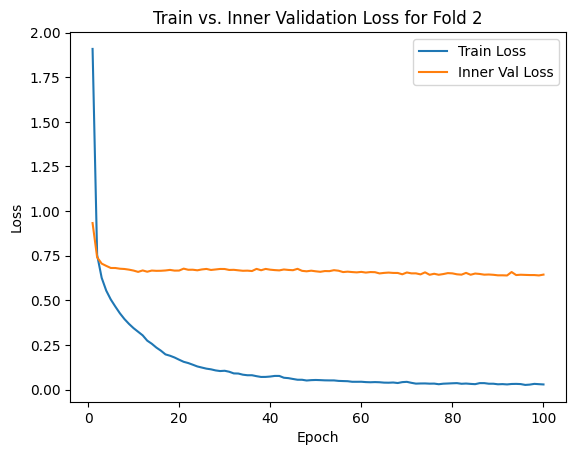

Fold 2 Spearman per protein: [0.10359872754602573, 0.45955312495236744, 0.05962897445599731, 0.7530639697716588, 0.48458272386580986, 0.3188125525167082, 0.18840665591565062, 0.4227331089467596, 0.4977944023886555, 0.20565035747890295, 0.4144336062657897, 0.23855995590197832, 0.3419882987024796, 0.2639516207437502, 0.6283228787506883, 0.7063253645307035, 0.618266002069127, 0.36702156954692156, 0.6754666314120106, 0.43697458994578264, 0.3522407833845282, 0.6333203910459901, 0.6128745732187905, 0.6223241098007182, 0.6726259024673531, 0.6633876988680008, 0.5424999093463077, 0.5832888332113842, 0.41346941225438394, 0.36170531747179374, 0.3612165247151845, 0.6573909773528581, 0.28330539784198366, 0.5379233551406742, 0.17626589612201268, 0.2762220064099895, 0.41396960207099504, 0.6449515691163713]
Fold 2 Average Spearman: 0.4472

=== Fold 3 ===
Epoch 1/100, Train Loss: 1.7487, Val Loss: 0.9339
Epoch 2/100, Train Loss: 0.7276, Val Loss: 0.7491
Epoch 3/100, Train Loss: 0.6126, Val Loss: 0.7048

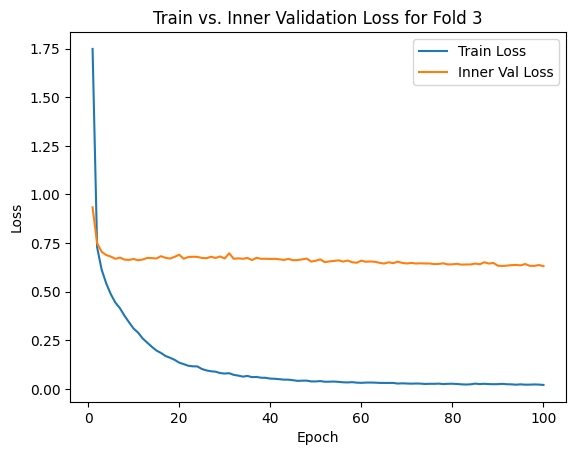

Fold 3 Spearman per protein: [0.09293986141760747, 0.4837390583508821, -0.008026954147528477, 0.7963812957922466, 0.5292869874207249, 0.3470498644347278, 0.2416011857040541, 0.4254893809541181, 0.4656453631282819, 0.26116311527353736, 0.44149052429978214, 0.2815814402908827, 0.2733883229594554, 0.26647811409340005, 0.6077212487667298, 0.7331443703691569, 0.6293599089127778, 0.30334639305028754, 0.6712933035727983, 0.4507110650059811, 0.3619798225691698, 0.6490908150649781, 0.6365876686829115, 0.6713711882304674, 0.6793298562620924, 0.6924437555392658, 0.4788398337288458, 0.6174507159383833, 0.47375790012047675, 0.3602939079284538, 0.37626947337789235, 0.6515440125621832, 0.2707691856484646, 0.5290131538052152, 0.18674787475970966, 0.24116968272694053, 0.45364982390873576, 0.6474024587915329]
Fold 3 Average Spearman: 0.4545

=== Fold 4 ===
Epoch 1/100, Train Loss: 1.6928, Val Loss: 0.8567
Epoch 2/100, Train Loss: 0.7298, Val Loss: 0.6964
Epoch 3/100, Train Loss: 0.6193, Val Loss: 0.6658

In [ ]:
groups = group_train.tolist()
gkf = GroupKFold(n_splits=len(np.unique(groups)))
all_fold_avg_spearman = []

best_model_state = None
best_avg_spearman = -np.inf
best_fold_index = -1

for fold, (train_idx, outer_val_idx) in enumerate(
        gkf.split(train_paths_q3_ii, train_labels_q3_ii, groups), 1):
    print(f"\n=== Fold {fold} ===")
    
    model = get_model()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
    [param for name, param in model.named_parameters() if 'layer4' in name or 'fc' in name],
    lr=1e-4)
    
    train_dataset = ProteinExpressionDataset(
        [train_paths_q3_ii[i] for i in train_idx],
        train_labels_q3_ii[train_idx],
        transform=data_transforms
    )
    outer_val_dataset = ProteinExpressionDataset(
        [train_paths_q3_ii[i] for i in outer_val_idx],
        train_labels_q3_ii[outer_val_idx],
        transform=data_transforms
    )
    
    inner_train_size = int(len(train_dataset) * 0.8)
    inner_val_size = len(train_dataset) - inner_train_size
    inner_train_dataset, inner_val_dataset = random_split(train_dataset, [inner_train_size, inner_val_size])
    
    inner_train_loader = DataLoader(inner_train_dataset, batch_size=128, shuffle=True)
    inner_val_loader = DataLoader(inner_val_dataset, batch_size=128, shuffle=False)
    outer_val_loader = DataLoader(outer_val_dataset, batch_size=128, shuffle=False)

    model, train_losses, val_losses = train_model_with_inner_validation(
        model, inner_train_loader, inner_val_loader, criterion, optimizer)
    
    plt.figure()
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Inner Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train vs. Inner Validation Loss for Fold {fold}')
    plt.legend()
    plt.show()
    
    val_preds, val_truths = evaluate_model(model, outer_val_loader)
    
    fold_spearman = [spearmanr(val_truths[:, i], val_preds[:, i])[0] for i in range(num_proteins)]
    avg_spearman = np.mean(fold_spearman)
    print(f"Fold {fold} Spearman per protein: {fold_spearman}")
    print(f"Fold {fold} Average Spearman: {avg_spearman:.4f}")
    all_fold_avg_spearman.append(avg_spearman)
    
    if avg_spearman > best_avg_spearman:
        best_avg_spearman = avg_spearman
        best_model_state = copy.deepcopy(model.state_dict())
        best_fold_index = fold

print(f"\nBest fold is Fold {best_fold_index} with Average Spearman: {best_avg_spearman:.4f}")

final_model = get_model()
final_model.load_state_dict(best_model_state)

final_dataset = ProteinExpressionDataset(train_paths_q3_ii, train_labels_q3_ii, transform=data_transforms)
train_size = int(0.8 * len(final_dataset))
val_size = len(final_dataset) - train_size
final_train_dataset, final_val_dataset = random_split(final_dataset, [train_size, val_size])

final_train_loader = DataLoader(final_train_dataset, batch_size=128, shuffle=True)
final_val_loader = DataLoader(final_val_dataset, batch_size=128, shuffle=False)

criterion_final = nn.MSELoss()
optimizer_final = optim.Adam(final_model.fc.parameters(), lr=1e-4)
num_epochs_final = 100

final_model, final_train_losses, final_val_losses = train_model_with_inner_validation(
    final_model, final_train_loader, final_val_loader, criterion_final, optimizer_final,
    epochs=num_epochs_final, save_interval=10
)

save_model(final_model, num_epochs_final, optimizer_final, final_train_losses[-1])
print("Final model training complete using the best performing model from k-fold CV.")

plt.figure()
plt.plot(range(1, len(final_train_losses) + 1), final_train_losses, label='Train Loss')
plt.plot(range(1, len(final_val_losses) + 1), final_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final Model: Training vs. Validation Loss')
plt.legend()
plt.show()

The below method is used to obtain the results for Q3ii.

In [19]:
def get_results_q3_ii(checkpoint, group_test):
    # lead the model
    final_model = resnet152(weights=ResNet152_Weights.DEFAULT)
    for param in final_model.parameters():
        param.requires_grad = False
    num_features = final_model.fc.in_features
    num_proteins = len(protein_list)
    final_model.fc = nn.Linear(num_features, num_proteins)
    final_model.load_state_dict(checkpoint['model_state_dict'])
    final_model = final_model.to(device)
    final_model.eval()

    # load the data
    resnet_test_dataset = ProteinExpressionDataset(test_paths_q3_ii, test_labels_q3_ii, transform=data_transforms)
    resnet_test_dataloader = DataLoader(resnet_test_dataset, batch_size=256, shuffle=False)

    # evaluate the model
    criterion = nn.MSELoss()
    test_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for imgs, targets in resnet_test_dataloader:
            imgs = imgs.to(device)
            targets = targets.to(device)
            outputs = final_model(imgs.float())
            loss = criterion(outputs, targets)
            test_loss += loss.item() * imgs.size(0)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    avg_test_loss = test_loss / len(resnet_test_dataset)
    print(f"Test Loss: {avg_test_loss:.4f}")

    # Compute metrics
    all_preds = np.concatenate(all_preds, axis=0)     
    all_targets = np.concatenate(all_targets, axis=0)

    group_test = group_test.tolist()
    test_groups = np.array(group_test)  

    unique_specimens = np.unique(test_groups)
    n_specimens = len(unique_specimens)

    # Compute metrics per protein
    rmse_by_specimen = np.zeros((n_specimens, num_proteins))
    pearson_by_specimen = np.zeros((n_specimens, num_proteins))
    spearman_by_specimen = np.zeros((n_specimens, num_proteins))
    r2_by_specimen = np.zeros((n_specimens, num_proteins))

    for i, specimen in enumerate(unique_specimens):
        specimen_idx = np.where(test_groups == specimen)[0]
        for p in range(num_proteins):
            y_true = all_targets[specimen_idx, p]
            y_pred = all_preds[specimen_idx, p]
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            pearson_corr, _ = pearsonr(y_true, y_pred)
            spearman_corr, _ = spearmanr(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            rmse_by_specimen[i, p] = rmse
            pearson_by_specimen[i, p] = pearson_corr
            spearman_by_specimen[i, p] = spearman_corr
            r2_by_specimen[i, p] = r2

    # Compute average metrics across proteins
    rmse_mean = rmse_by_specimen.mean(axis=0)
    rmse_std  = rmse_by_specimen.std(axis=0)
    pearson_mean = pearson_by_specimen.mean(axis=0)
    pearson_std  = pearson_by_specimen.std(axis=0)
    spearman_mean = spearman_by_specimen.mean(axis=0)
    spearman_std  = spearman_by_specimen.std(axis=0)
    r2_mean = r2_by_specimen.mean(axis=0)
    r2_std  = r2_by_specimen.std(axis=0)

    summary_table = pd.DataFrame({
        'Protein': protein_list,
        'RMSE_mean': rmse_mean,
        'RMSE_std': rmse_std,
        'Pearson_mean': pearson_mean,
        'Pearson_std': pearson_std,
        'Spearman_mean': spearman_mean,
        'Spearman_std': spearman_std,
        'R2_mean': r2_mean,
        'R2_std': r2_std
    })

    summary_table = summary_table.round(3)

    print("\nPerformance Summary per Protein:")
    print(summary_table)

    #  report the number of proteins for which the average spearman correlation coefficient is above 0.7.
    num_proteins_above = np.sum(spearman_mean > 0.7)
    print(f"\nNumber of proteins with average Spearman correlation > 0.7: {num_proteins_above}")

    n_cols = 6
    n_rows = int(np.ceil(num_proteins / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3), squeeze=False)

    for idx, protein in enumerate(protein_list):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        ax.scatter(all_targets[:, idx], all_preds[:, idx], alpha=0.6)
        ax.plot([all_targets[:, idx].min(), all_targets[:, idx].max()],
                [all_targets[:, idx].min(), all_targets[:, idx].max()],
                'r--')
        ax.set_title(f"{protein}\nSpearman: {spearman_mean[idx]:.2f}")
        ax.set_xlabel("True")
        ax.set_ylabel("Predicted")

    # remove unused subplots
    for idx in range(num_proteins, n_rows * n_cols):
        fig.delaxes(axes[idx // n_cols, idx % n_cols])
        
    plt.tight_layout()
    plt.show()

Below, we show the model trained with only the final fully connected layer. We observe that there are no proteins with an average Spearman correlation greater than 0.7. This model does not perform as well compared to the models with layer 4 and layer 3 unfrozen.

However, the model still shows some improvements in CD11b prediction compared to the models from Q2 and Q3i, with the correlation coefficients being much higher (0.542 compared to 3.331 on Pearson correlation).

This table show all the results:
| Protein  | RMSE_mean | RMSE_std | Pearson_mean | Pearson_std | Spearman_mean | Spearman_std | R2_mean | R2_std |
|----------|-----------|----------|--------------|-------------|---------------|--------------|---------|--------|
| SMAa     | 0.800     | 0.020    | 0.151        | 0.057       | 0.085         | 0.018        | -0.113  | 0.055  |
| CD44     | 0.650     | 0.038    | 0.314        | 0.054       | 0.324         | 0.040        | -0.006  | 0.073  |
| CD31     | 0.636     | 0.029    | 0.056        | 0.079       | 0.047         | 0.029        | -0.227  | 0.077  |
| CDK4     | 0.878     | 0.037    | 0.615        | 0.022       | 0.639         | 0.022        | 0.358   | 0.036  |
| YKL40    | 0.413     | 0.050    | 0.491        | 0.076       | 0.378         | 0.040        | 0.185   | 0.095  |
| CD11c    | 0.927     | 0.014    | 0.284        | 0.030       | 0.297         | 0.034        | -0.031  | 0.039  |
| HIF1a    | 0.832     | 0.043    | 0.361        | 0.043       | 0.201         | 0.029        | 0.072   | 0.063  |
| CD24     | 1.220     | 0.061    | 0.336        | 0.042       | 0.336         | 0.045        | 0.021   | 0.056  |
| TMEM119  | 1.381     | 0.111    | 0.516        | 0.023       | 0.348         | 0.058        | 0.211   | 0.059  |
| OLIG2    | 1.062     | 0.063    | 0.200        | 0.044       | 0.181         | 0.043        | -0.076  | 0.031  |
| GFAP     | 0.778     | 0.031    | 0.480        | 0.036       | 0.301         | 0.026        | 0.178   | 0.058  |
| VISTA    | 0.847     | 0.030    | 0.198        | 0.019       | 0.217         | 0.033        | -0.108  | 0.019  |
| IBA1     | 0.994     | 0.037    | 0.284        | 0.040       | 0.243         | 0.032        | -0.014  | 0.056  |
| CD206    | 0.674     | 0.047    | 0.212        | 0.054       | 0.233         | 0.058        | -0.144  | 0.090  |
| PTEN     | 0.982     | 0.124    | 0.602        | 0.064       | 0.441         | 0.030        | 0.342   | 0.087  |
| NESTIN   | 0.549     | 0.025    | 0.600        | 0.027       | 0.650         | 0.038        | 0.325   | 0.052  |
| TCIRG1   | 0.775     | 0.075    | 0.592        | 0.024       | 0.478         | 0.027        | 0.305   | 0.042  |
| CD74     | 0.867     | 0.031    | 0.284        | 0.057       | 0.252         | 0.044        | -0.053  | 0.099  |
| MET      | 0.768     | 0.081    | 0.660        | 0.027       | 0.510         | 0.018        | 0.426   | 0.040  |
| P2RY12   | 1.034     | 0.018    | 0.390        | 0.024       | 0.365         | 0.041        | 0.091   | 0.036  |
| CD163    | 0.813     | 0.074    | 0.234        | 0.075       | 0.286         | 0.069        | -0.094  | 0.065  |
| S100B    | 0.723     | 0.082    | 0.581        | 0.036       | 0.528         | 0.023        | 0.306   | 0.036  |
| cMYC     | 1.144     | 0.094    | 0.590        | 0.018       | 0.474         | 0.024        | 0.319   | 0.036  |
| pERK     | 1.238     | 0.061    | 0.518        | 0.024       | 0.539         | 0.027        | 0.237   | 0.037  |
| EGFR     | 0.242     | 0.012    | 0.600        | 0.030       | 0.539         | 0.051        | 0.322   | 0.043  |
| SOX2     | 0.859     | 0.037    | 0.517        | 0.034       | 0.542         | 0.035        | 0.219   | 0.049  |
| HLADR    | 0.940     | 0.050    | 0.427        | 0.035       | 0.402         | 0.015        | 0.097   | 0.087  |
| PDGFRa   | 0.954     | 0.110    | 0.577        | 0.020       | 0.379         | 0.020        | 0.291   | 0.056  |
| MCT4     | 0.798     | 0.068    | 0.304        | 0.050       | 0.247         | 0.030        | -0.078  | 0.072  |
| DNA1     | 0.540     | 0.014    | 0.294        | 0.029       | 0.305         | 0.024        | -0.023  | 0.046  |
| DNA3     | 0.541     | 0.014    | 0.291        | 0.029       | 0.301         | 0.025        | -0.027  | 0.047  |
| MHCI     | 0.401     | 0.018    | 0.530        | 0.044       | 0.548         | 0.043        | 0.214   | 0.094  |
| CD68     | 0.845     | 0.043    | 0.250        | 0.053       | 0.230         | 0.052        | -0.054  | 0.048  |
| CD14     | 0.817     | 0.039    | 0.439        | 0.020       | 0.464         | 0.023        | 0.130   | 0.041  |
| KI67     | 0.751     | 0.013    | 0.138        | 0.015       | 0.132         | 0.009        | -0.159  | 0.028  |
| CD16     | 0.808     | 0.032    | 0.201        | 0.037       | 0.185         | 0.037        | -0.102  | 0.041  |
| SOX10    | 1.099     | 0.039    | 0.397        | 0.036       | 0.372         | 0.051        | 0.095   | 0.040  |
| CD11b    | 1.278     | 0.005    | 0.542        | 0.017       | 0.545         | 0.018        | 0.259   | 0.021  |


Test Loss: 0.7581

Performance Summary per Protein:
    Protein  RMSE_mean  RMSE_std  Pearson_mean  Pearson_std  Spearman_mean  \
0      SMAa      0.800     0.020         0.151        0.057          0.085   
1      CD44      0.650     0.038         0.314        0.054          0.324   
2      CD31      0.636     0.029         0.056        0.079          0.047   
3      CDK4      0.878     0.037         0.615        0.022          0.639   
4     YKL40      0.413     0.050         0.491        0.076          0.378   
5     CD11c      0.927     0.014         0.284        0.030          0.297   
6     HIF1a      0.832     0.043         0.361        0.043          0.201   
7      CD24      1.220     0.061         0.336        0.042          0.336   
8   TMEM119      1.381     0.111         0.516        0.023          0.348   
9     OLIG2      1.062     0.063         0.200        0.044          0.181   
10     GFAP      0.778     0.031         0.480        0.036          0.301   
11    VISTA 

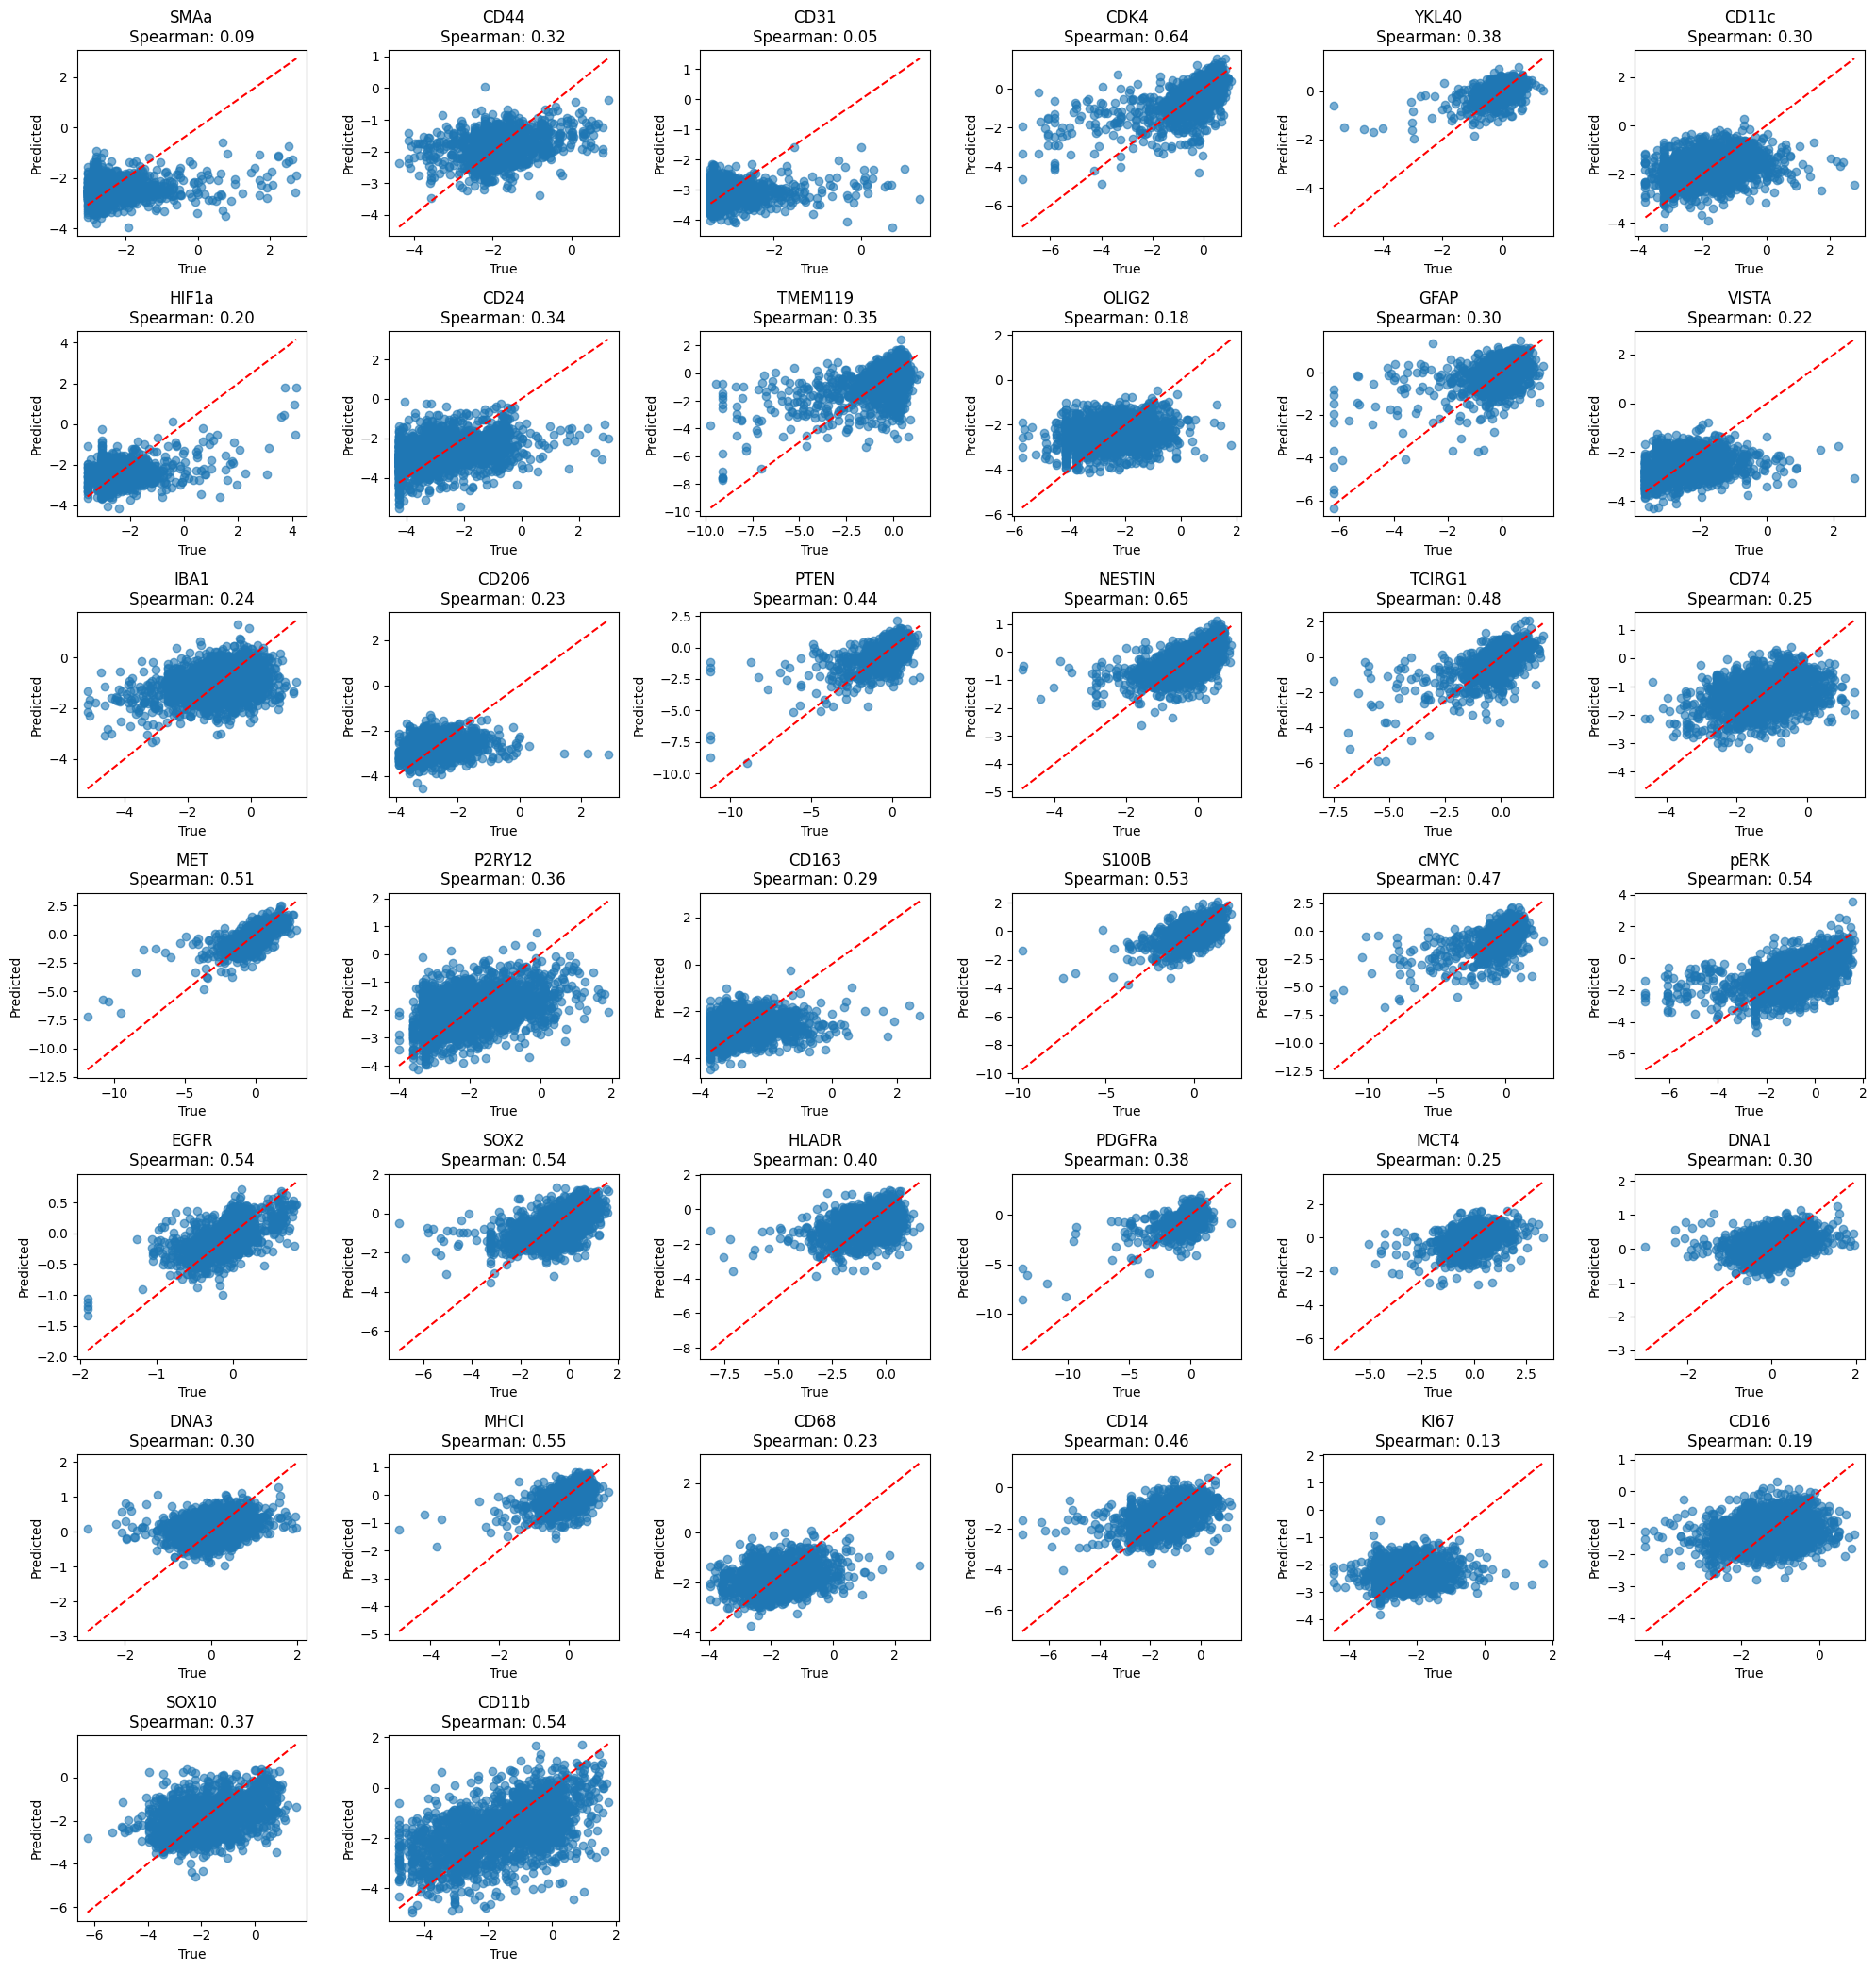

In [20]:
# this is the model with only the final layer trained - the added fully connected layer
model_path = '/Users/msakaki/Desktop/909/cw2/resnet152_fc_train_hed_minmax.pth'
checkpoint = torch.load(model_path, map_location=device)
get_results_q3_ii(checkpoint, group_test)

The model below was trained with both the final fully connected layer and layer 4 unfrozen. We can see that it performs better than the model with only the final layer unfrozen across all metrics, with higher correlations, R² values, and lower RMSE.

Additionally, there are two proteins with an average Spearman correlation greater than 0.7: CDK4 and NESTIN. Moreover, several proteins have a correlation greater than 0.6, including TCIRG1, PTEN, MET, S100B, cMYC, pERK, EGFR, SOX2, PDGFRa, MHCI, and CD11b. We also observe that CD11b performs better compared to its performance in Q3i and Q2, suggesting there could be a difference between Specimen A1 and the other specimens.

This is the most time-consuming model to train, requiring about 6 hours on Kudu with Falcon. However, the improvements with layer 4 unfrozen are significant—the number of proteins with issues decreased from 16 to 4—suggesting that the model is performing significantly better than the base model and is, therefore, more relevant. The graphs plotted also show that many of the proteins follow the best-fit line—about half of the proteins—further indicating that our model is performing well.

The table below show the results from this model. 
| Protein  | RMSE_mean | RMSE_std | Pearson_mean | Pearson_std | Spearman_mean | Spearman_std | R2_mean | R2_std |
|----------|-----------|----------|--------------|-------------|---------------|--------------|---------|--------|
| SMAa     | 0.762     | 0.021    | 0.203        | 0.066       | 0.074         | 0.039        | -0.008  | 0.046  |
| CD44     | 0.583     | 0.026    | 0.468        | 0.078       | 0.466         | 0.049        | 0.183   | 0.110  |
| CD31     | 0.607     | 0.028    | 0.081        | 0.070       | 0.040         | 0.030        | -0.117  | 0.064  |
| CDK4     | 0.763     | 0.061    | 0.721        | 0.028       | 0.768         | 0.014        | 0.517   | 0.041  |
| YKL40    | 0.362     | 0.045    | 0.625        | 0.047       | 0.500         | 0.022        | 0.379   | 0.052  |
| CD11c    | 0.878     | 0.024    | 0.344        | 0.032       | 0.354         | 0.048        | 0.076   | 0.039  |
| HIF1a    | 0.784     | 0.038    | 0.431        | 0.064       | 0.234         | 0.066        | 0.176   | 0.060  |
| CD24     | 1.116     | 0.089    | 0.445        | 0.051       | 0.433         | 0.050        | 0.183   | 0.055  |
| TMEM119  | 1.196     | 0.144    | 0.649        | 0.018       | 0.516         | 0.011        | 0.415   | 0.026  |
| OLIG2    | 1.001     | 0.046    | 0.290        | 0.028       | 0.264         | 0.030        | 0.042   | 0.035  |
| GFAP     | 0.694     | 0.037    | 0.598        | 0.037       | 0.470         | 0.014        | 0.347   | 0.045  |
| VISTA    | 0.798     | 0.023    | 0.268        | 0.026       | 0.281         | 0.033        | 0.015   | 0.028  |
| IBA1     | 0.924     | 0.035    | 0.381        | 0.029       | 0.345         | 0.018        | 0.125   | 0.033  |
| CD206    | 0.643     | 0.027    | 0.245        | 0.002       | 0.260         | 0.025        | -0.043  | 0.024  |
| PTEN     | 0.838     | 0.083    | 0.724        | 0.018       | 0.628         | 0.028        | 0.522   | 0.026  |
| NESTIN   | 0.490     | 0.030    | 0.686        | 0.020       | 0.747         | 0.023        | 0.465   | 0.029  |
| TCIRG1   | 0.659     | 0.072    | 0.709        | 0.017       | 0.636         | 0.009        | 0.499   | 0.025  |
| CD74     | 0.810     | 0.037    | 0.363        | 0.081       | 0.348         | 0.045        | 0.080   | 0.100  |
| MET      | 0.638     | 0.064    | 0.782        | 0.016       | 0.696         | 0.023        | 0.604   | 0.022  |
| P2RY12   | 0.949     | 0.035    | 0.502        | 0.022       | 0.490         | 0.035        | 0.235   | 0.024  |
| CD163    | 0.762     | 0.090    | 0.306        | 0.113       | 0.390         | 0.085        | 0.040   | 0.111  |
| S100B    | 0.614     | 0.048    | 0.708        | 0.015       | 0.638         | 0.037        | 0.497   | 0.021  |
| cMYC     | 0.991     | 0.098    | 0.705        | 0.020       | 0.612         | 0.018        | 0.492   | 0.022  |
| pERK     | 1.056     | 0.069    | 0.671        | 0.023       | 0.691         | 0.034        | 0.446   | 0.031  |
| EGFR     | 0.200     | 0.012    | 0.738        | 0.010       | 0.674         | 0.034        | 0.541   | 0.016  |
| SOX2     | 0.750     | 0.049    | 0.645        | 0.020       | 0.675         | 0.012        | 0.406   | 0.015  |
| HLADR    | 0.847     | 0.061    | 0.536        | 0.068       | 0.541         | 0.041        | 0.264   | 0.106  |
| PDGFRa   | 0.801     | 0.116    | 0.713        | 0.029       | 0.601         | 0.010        | 0.504   | 0.042  |
| MCT4     | 0.708     | 0.065    | 0.439        | 0.050       | 0.423         | 0.057        | 0.153   | 0.061  |
| DNA1     | 0.503     | 0.019    | 0.388        | 0.027       | 0.391         | 0.024        | 0.114   | 0.030  |
| DNA3     | 0.506     | 0.020    | 0.379        | 0.027       | 0.384         | 0.024        | 0.104   | 0.029  |
| MHCI     | 0.370     | 0.018    | 0.603        | 0.052       | 0.638         | 0.038        | 0.328   | 0.096  |
| CD68     | 0.819     | 0.059    | 0.275        | 0.070       | 0.269         | 0.069        | 0.011   | 0.071  |
| CD14     | 0.769     | 0.044    | 0.503        | 0.034       | 0.538         | 0.024        | 0.231   | 0.047  |
| KI67     | 0.721     | 0.013    | 0.206        | 0.040       | 0.206         | 0.049        | -0.068  | 0.062  |
| CD16     | 0.768     | 0.036    | 0.273        | 0.061       | 0.255         | 0.064        | 0.002   | 0.080  |
| SOX10    | 0.991     | 0.033    | 0.523        | 0.046       | 0.473         | 0.050        | 0.263   | 0.053  |
| CD11b    | 1.128     | 0.021    | 0.659        | 0.017       | 0.661         | 0.017        | 0.423   | 0.027  |


Test Loss: 0.6191

Performance Summary per Protein:
    Protein  RMSE_mean  RMSE_std  Pearson_mean  Pearson_std  Spearman_mean  \
0      SMAa      0.762     0.021         0.203        0.066          0.074   
1      CD44      0.583     0.026         0.468        0.078          0.466   
2      CD31      0.607     0.028         0.081        0.070          0.040   
3      CDK4      0.763     0.061         0.721        0.028          0.768   
4     YKL40      0.362     0.045         0.625        0.047          0.500   
5     CD11c      0.878     0.024         0.344        0.032          0.354   
6     HIF1a      0.784     0.038         0.431        0.064          0.234   
7      CD24      1.116     0.089         0.445        0.051          0.433   
8   TMEM119      1.196     0.144         0.649        0.018          0.516   
9     OLIG2      1.001     0.046         0.290        0.028          0.264   
10     GFAP      0.694     0.037         0.598        0.037          0.470   
11    VISTA 

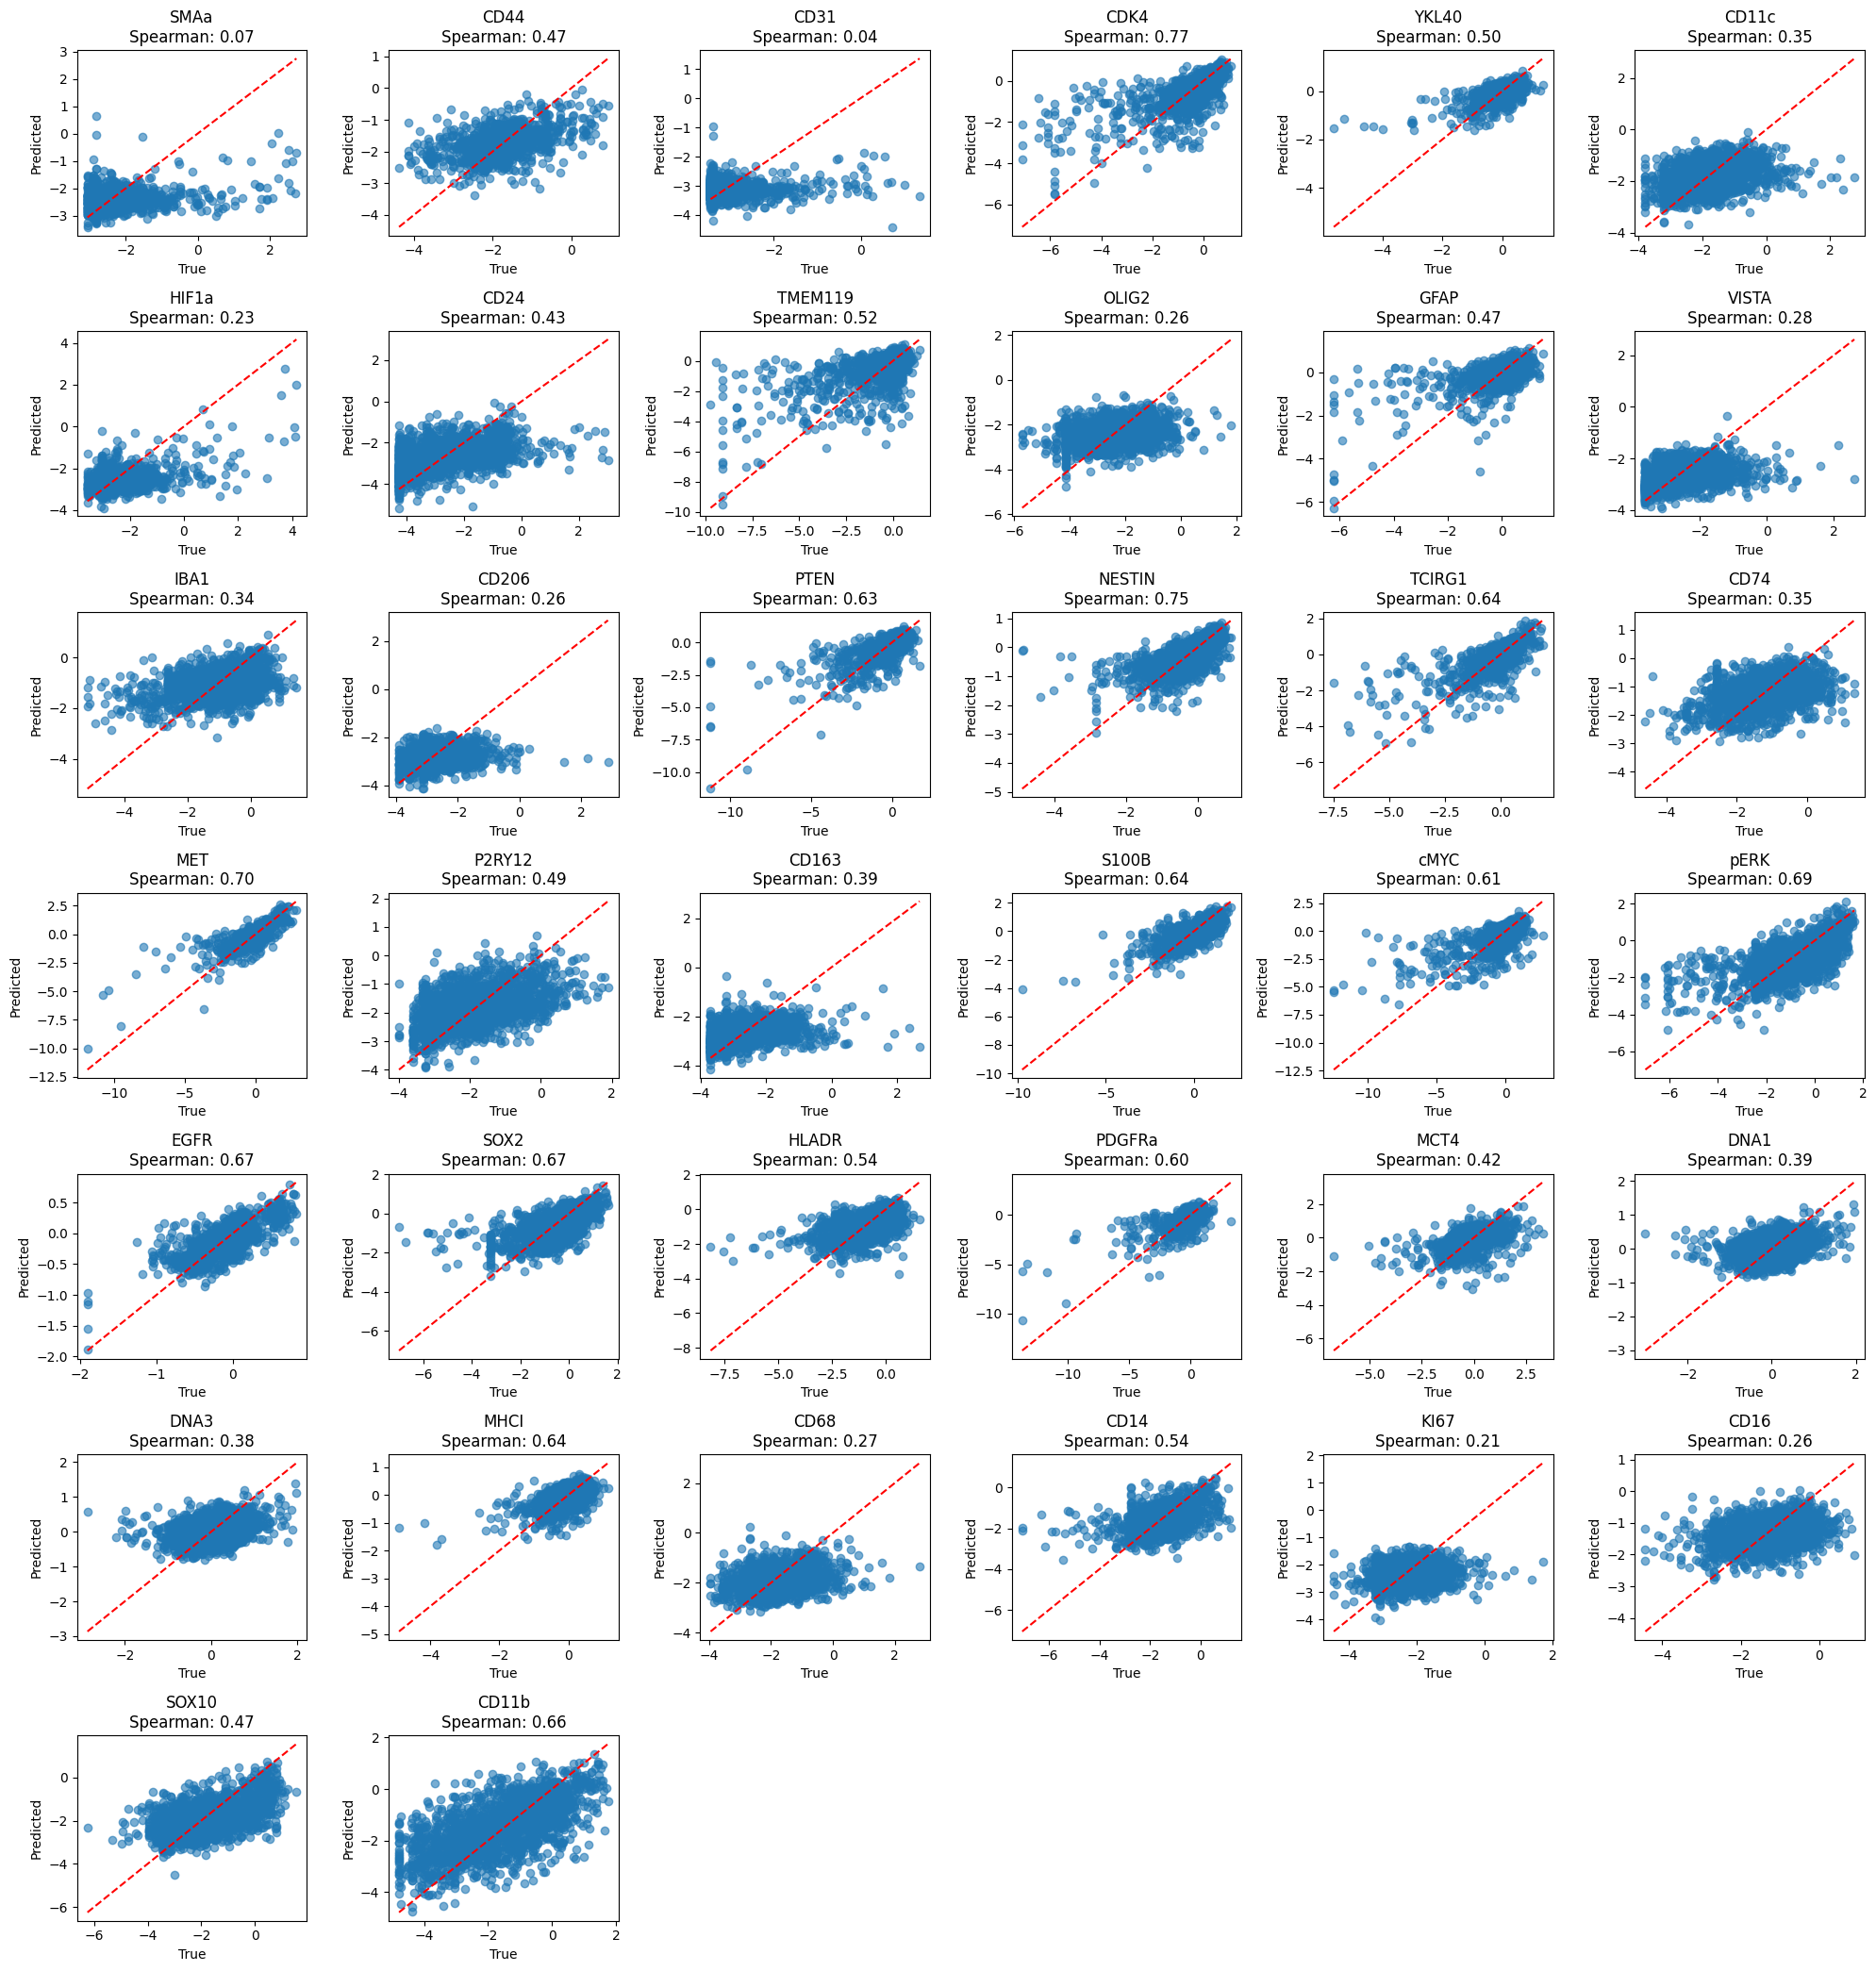

In [15]:
# this is the model with final fully connected layer and layer 4 trained
model_path = '/Users/msakaki/Desktop/909/cw2/resnet152_fc_layer4_train_hed_minmax.pth'
checkpoint = torch.load(model_path, map_location=device)
get_results_q3_ii(checkpoint, group_test)

This model was trained with layer 4 and layer 3 unfrozen during group K-fold cross-validation. We observe that its performance is similar to the model with only layer 4 unfrozen, with the same number and the exact same proteins having an average Spearman correlation greater than 0.7. Comparing the two models, we see that there is an improvement in some metrics for certain proteins (e.g., SMAa's RMSE dropped from 0.762 to 0.742), and fewer negative R² values (dropped from 4 proteins with negative values to 3).
But decreases in performance for others (e.g., YKL40's RMSE increased from 0.362 to 0.364). The changes are very small, so we conclude that there will not be a significant difference in performance if we further unfreeze the model. Although training more of the model's parameters should slightly improve performance, the available time and resources are insufficient, and the data may not be enough to effectively train a 152-layer network. Therefore, unfreezing only the final fully connected layer and layer 4 appears to be the best choice for balancing cost and performance.

Additionally, the graph plotting the actual and predicted values for each protein shows that some proteins align with the best-fit line quite well (e.g., MET), while others perform poorly (e.g., CD31). This indicates that the model is able to predict values for some proteins effectively but performs poorly on others. This could be due to the fact that the features for the expression of some proteins are visually difficult to identify or that the data does not provide enough features for the model to make a meaningful interpretation.

The table below show the model performance across metrics.
| Protein  | RMSE_mean | RMSE_std | Pearson_mean | Pearson_std | Spearman_mean | Spearman_std | R2_mean | R2_std |
|----------|-----------|----------|--------------|-------------|---------------|--------------|---------|--------|
| SMAa     | 0.742     | 0.015    | 0.261        | 0.090       | 0.106         | 0.041        | 0.042   | 0.069  |
| CD44     | 0.582     | 0.023    | 0.467        | 0.078       | 0.475         | 0.061        | 0.189   | 0.094  |
| CD31     | 0.585     | 0.018    | 0.160        | 0.087       | 0.065         | 0.052        | -0.040  | 0.067  |
| CDK4     | 0.757     | 0.067    | 0.726        | 0.043       | 0.795         | 0.008        | 0.522   | 0.063  |
| YKL40    | 0.364     | 0.055    | 0.616        | 0.096       | 0.511         | 0.024        | 0.368   | 0.118  |
| CD11c    | 0.873     | 0.030    | 0.346        | 0.041       | 0.378         | 0.050        | 0.085   | 0.049  |
| HIF1a    | 0.770     | 0.020    | 0.457        | 0.074       | 0.275         | 0.052        | 0.204   | 0.073  |
| CD24     | 1.101     | 0.083    | 0.464        | 0.039       | 0.436         | 0.071        | 0.205   | 0.038  |
| TMEM119  | 1.214     | 0.126    | 0.636        | 0.039       | 0.525         | 0.015        | 0.393   | 0.047  |
| OLIG2    | 0.999     | 0.030    | 0.281        | 0.042       | 0.266         | 0.055        | 0.044   | 0.056  |
| GFAP     | 0.690     | 0.031    | 0.604        | 0.034       | 0.461         | 0.021        | 0.354   | 0.045  |
| VISTA    | 0.783     | 0.033    | 0.295        | 0.035       | 0.292         | 0.038        | 0.053   | 0.039  |
| IBA1     | 0.909     | 0.039    | 0.404        | 0.057       | 0.345         | 0.041        | 0.153   | 0.054  |
| CD206    | 0.631     | 0.029    | 0.268        | 0.038       | 0.294         | 0.035        | -0.001  | 0.027  |
| PTEN     | 0.822     | 0.090    | 0.741        | 0.019       | 0.652         | 0.027        | 0.541   | 0.028  |
| NESTIN   | 0.483     | 0.033    | 0.697        | 0.018       | 0.762         | 0.012        | 0.480   | 0.028  |
| TCIRG1   | 0.678     | 0.094    | 0.691        | 0.052       | 0.652         | 0.028        | 0.469   | 0.073  |
| CD74     | 0.797     | 0.025    | 0.387        | 0.075       | 0.372         | 0.058        | 0.110   | 0.089  |
| MET      | 0.647     | 0.090    | 0.776        | 0.027       | 0.692         | 0.015        | 0.595   | 0.042  |
| P2RY12   | 0.925     | 0.030    | 0.531        | 0.008       | 0.507         | 0.016        | 0.274   | 0.003  |
| CD163    | 0.746     | 0.089    | 0.329        | 0.132       | 0.399         | 0.092        | 0.079   | 0.110  |
| S100B    | 0.611     | 0.058    | 0.712        | 0.022       | 0.668         | 0.018        | 0.502   | 0.037  |
| cMYC     | 0.999     | 0.103    | 0.698        | 0.049       | 0.631         | 0.010        | 0.479   | 0.070  |
| pERK     | 1.054     | 0.067    | 0.674        | 0.013       | 0.685         | 0.023        | 0.449   | 0.018  |
| EGFR     | 0.198     | 0.013    | 0.745        | 0.016       | 0.692         | 0.020        | 0.549   | 0.027  |
| SOX2     | 0.752     | 0.038    | 0.640        | 0.011       | 0.687         | 0.008        | 0.403   | 0.009  |
| HLADR    | 0.823     | 0.040    | 0.566        | 0.066       | 0.567         | 0.034        | 0.303   | 0.097  |
| PDGFRa   | 0.834     | 0.145    | 0.690        | 0.034       | 0.592         | 0.019        | 0.468   | 0.051  |
| MCT4     | 0.694     | 0.063    | 0.456        | 0.036       | 0.446         | 0.033        | 0.185   | 0.039  |
| DNA1     | 0.503     | 0.018    | 0.393        | 0.053       | 0.411         | 0.038        | 0.114   | 0.061  |
| DNA3     | 0.497     | 0.013    | 0.410        | 0.039       | 0.422         | 0.027        | 0.135   | 0.045  |
| MHCI     | 0.366     | 0.037    | 0.609        | 0.078       | 0.651         | 0.048        | 0.344   | 0.110  |
| CD68     | 0.802     | 0.038    | 0.296        | 0.063       | 0.266         | 0.066        | 0.048   | 0.060  |
| CD14     | 0.762     | 0.050    | 0.509        | 0.026       | 0.545         | 0.025        | 0.246   | 0.028  |
| KI67     | 0.702     | 0.027    | 0.231        | 0.042       | 0.230         | 0.036        | -0.012  | 0.034  |
| CD16     | 0.757     | 0.031    | 0.292        | 0.051       | 0.299         | 0.040        | 0.031   | 0.059  |
| SOX10    | 0.978     | 0.036    | 0.541        | 0.049       | 0.489         | 0.052        | 0.282   | 0.053  |
| CD11b    | 1.100     | 0.024    | 0.675        | 0.023       | 0.677         | 0.021        | 0.451   | 0.034  |


Test Loss: 0.6029

Performance Summary per Protein:
    Protein  RMSE_mean  RMSE_std  Pearson_mean  Pearson_std  Spearman_mean  \
0      SMAa      0.742     0.015         0.261        0.090          0.106   
1      CD44      0.582     0.023         0.467        0.078          0.475   
2      CD31      0.585     0.018         0.160        0.087          0.065   
3      CDK4      0.757     0.067         0.726        0.043          0.795   
4     YKL40      0.364     0.055         0.616        0.096          0.511   
5     CD11c      0.873     0.030         0.346        0.041          0.378   
6     HIF1a      0.770     0.020         0.457        0.074          0.275   
7      CD24      1.101     0.083         0.464        0.039          0.436   
8   TMEM119      1.214     0.126         0.636        0.039          0.525   
9     OLIG2      0.999     0.030         0.281        0.042          0.266   
10     GFAP      0.690     0.031         0.604        0.034          0.461   
11    VISTA 

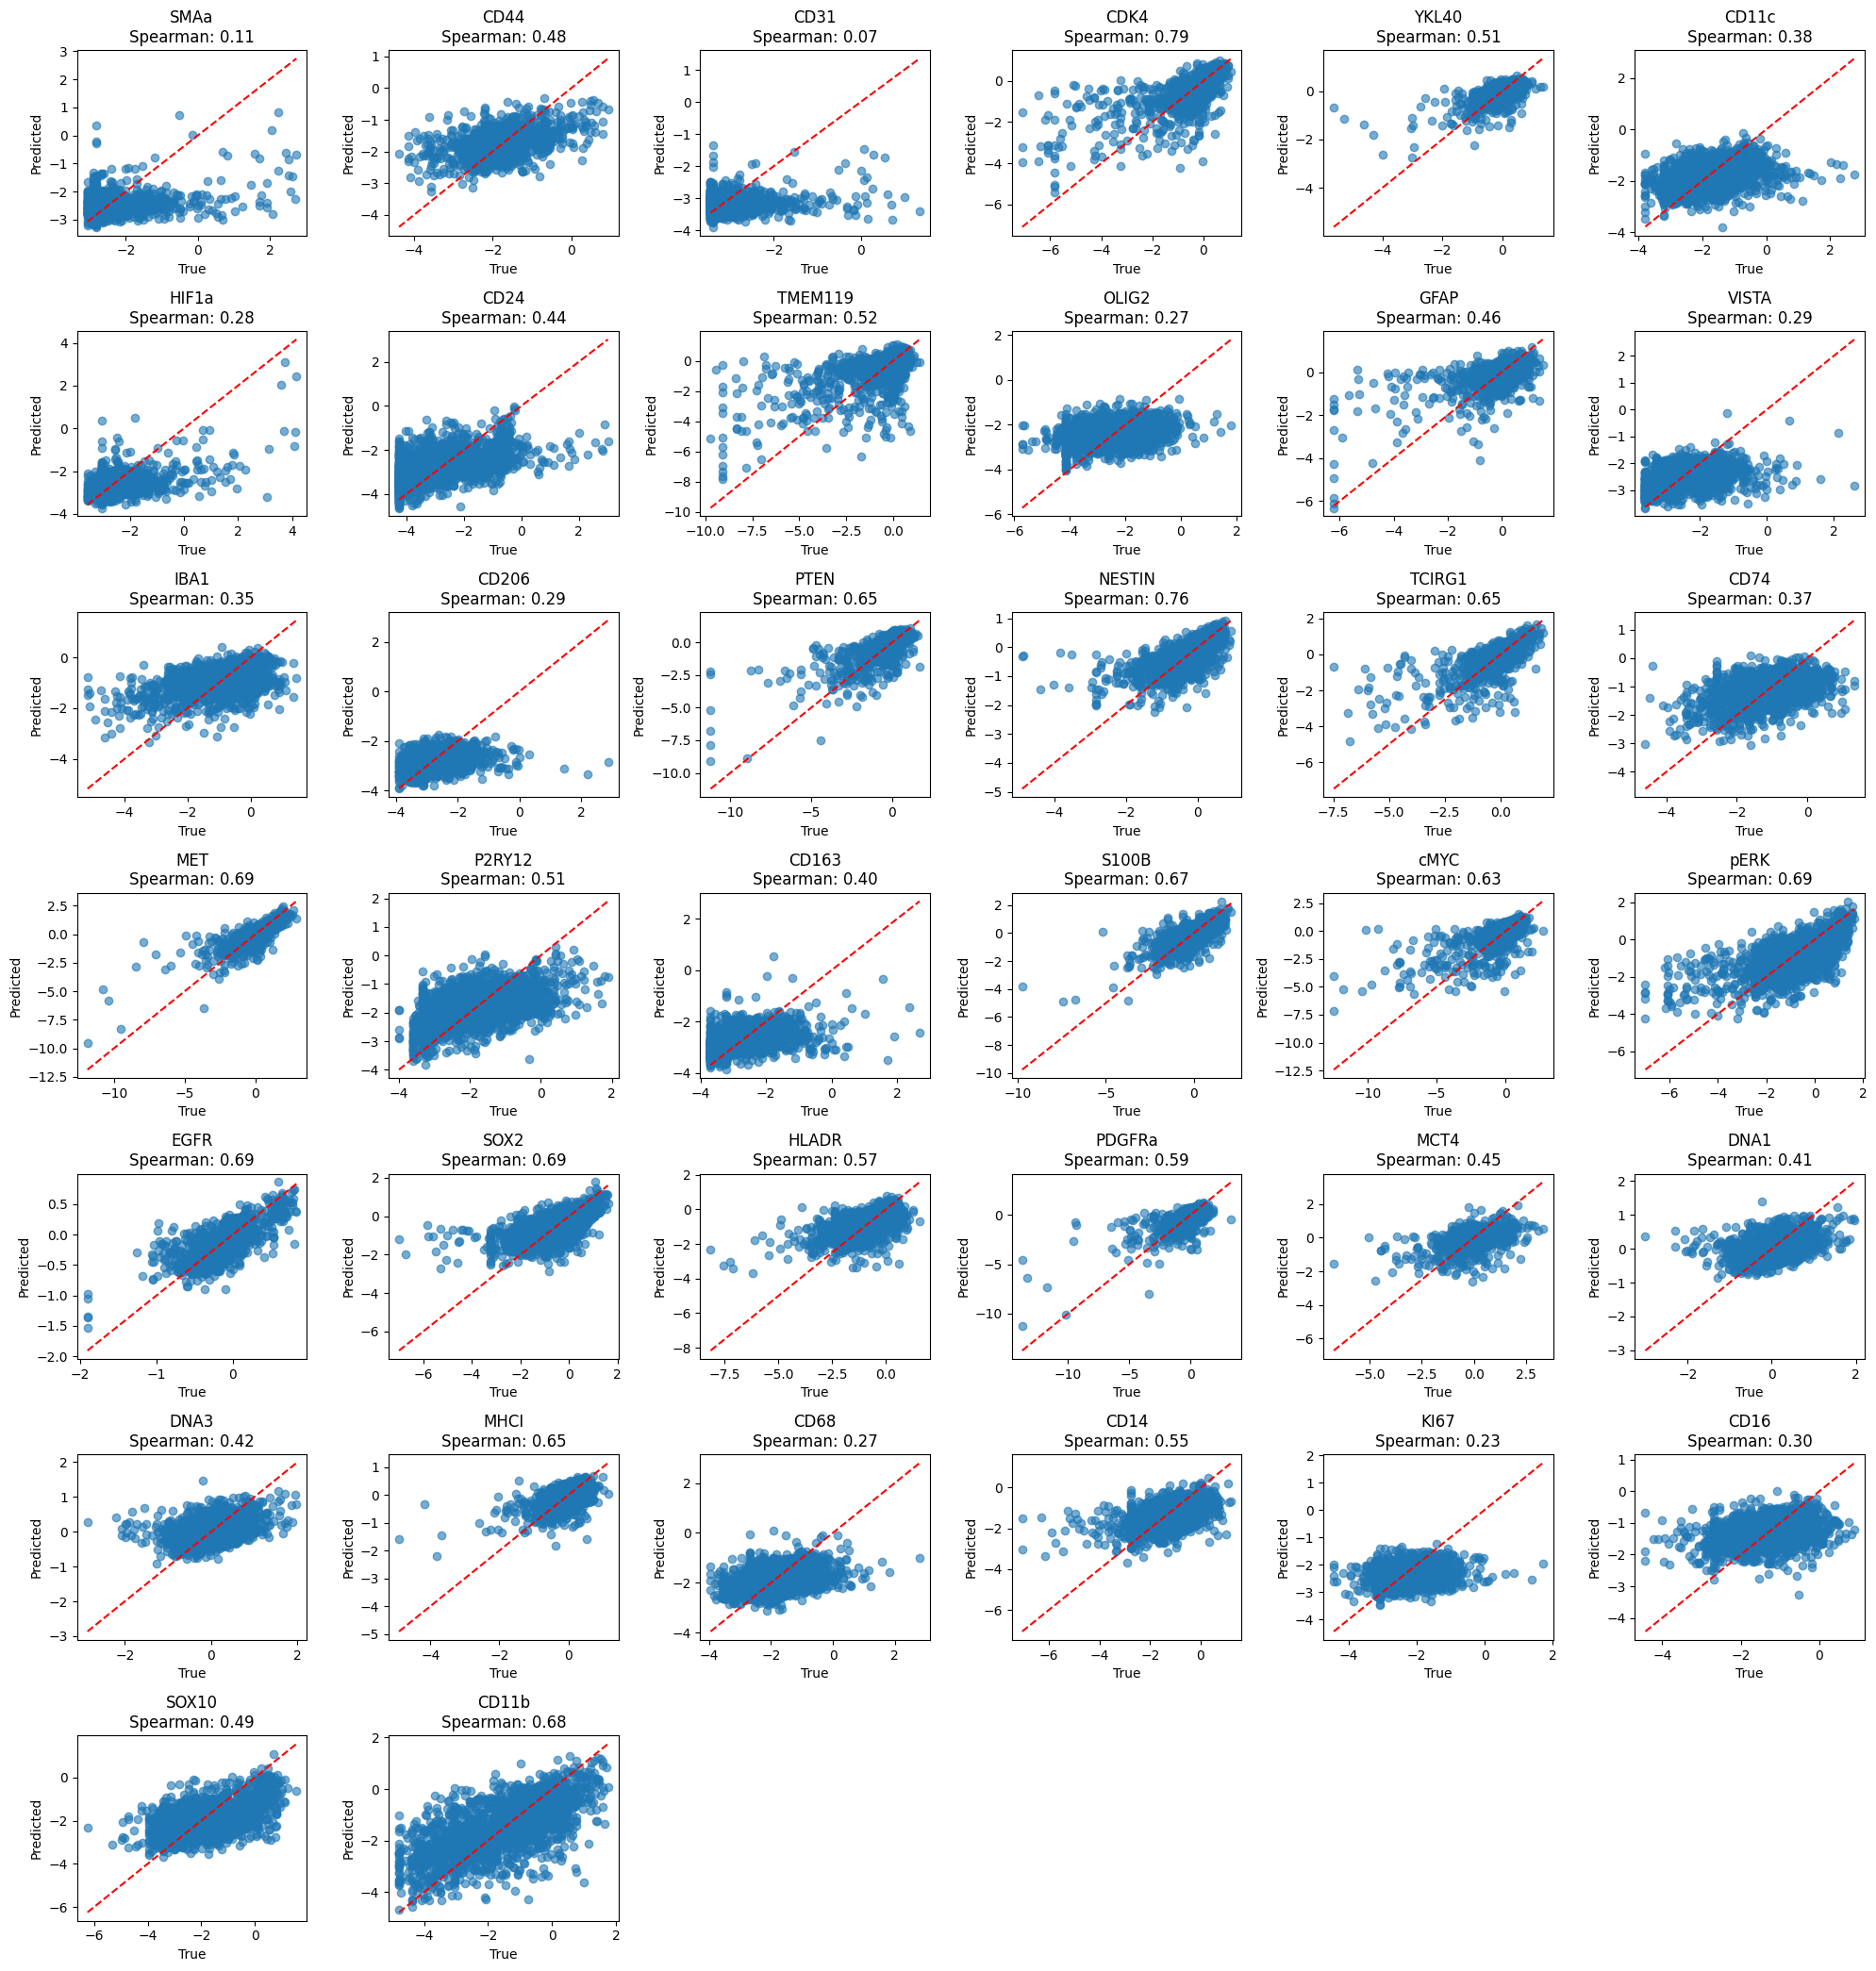

In [16]:
# this is the model with final fully connected layer and layer 4 and layer 3 trained
model_path = '/Users/msakaki/Desktop/909/cw2/model_checkpoint_q3_ii_withlayer4andlayer3.pth'
checkpoint = torch.load(model_path, map_location=device)
get_results_q3_ii(checkpoint, group_test)

## iii
### A
The HED colour space provides information from different parts of the cell:

- **H channel:** Highlights the nuclei of cells.
- **E channel:** Highlights cytoplasmic structures and the extracellular matrix.
- **DAB channel:** Used to label the protein of interest; it directly reflects the intensity and localization of protein expression.

Protein expression can be observed in different cellular structures. For example, if a protein is mainly present on the cell membrane, we can use the E channel from the HED colour space to assess its expression. Conversely, if a protein’s expression is related to noticeable changes in the nucleus, then the H channel would be more informative. The DAB channel generally provides the most direct information, as it highlights the intensity of protein expression.

Additionally, location data may be useful because some proteins might be expressed more in certain areas of the tissue due to local microenvironmental conditions.
Neighborhood statistics, such as the average expression level in adjacent spots, can be sued to capture local heterogeneity, that can help model performance. 
Visualizing the spatial distribution of protein expression can also help uncover latent structures that might be critical for improving prediction performance. 

### B
This is the collinearity problem, where there are multiple correlated variables.

When there is multicollinearity, several issues can arise:
- **Unstable coefficients:** Small changes in the data can lead to large changes in the coefficients, resulting in an inaccurate judgment of the relationship between the independent and dependent variables.
- **Inflated standard errors:** The confidence intervals for the coefficients become wider, making it difficult to determine the statistical significance of the variables.
- **Compromised interpretation:** The interpretation of a coefficient as the effect of changing one variable while holding the others constant becomes meaningless when the variables are highly correlated.

We can use the variance inflation factor (VIF) to test for multicollinearity; a VIF of 10 or more for two variables (or proteins) indicates collinearity.

Alternatively, we can use PCA (Principal Component Analysis) to reduce collinearity, or apply regularization techniques such as L1 or L2 to stabilize the coefficients. Another method is to remove the correlated variables by eliminating one of them or by combining the correlated variables into a single variable (e.g., by averaging or summing them).
